## Disclaimer
*The fia package and any results received by using the fia package are for informational and educational purposes only. You should not construe any such information or other material as
legal, tax, investment, financial, or other advice. There are risks associated with investing in any securities and assets. Do your own research. 
Past performance is not a guarantee of future return or performance. You may gain or lose money.*

# The weekend gap between CME and Binance BTC prices

The goal is to estimate the difference between CME and BTC prices during weekends and understand how it can be used.

CME trading hours: Sunday - Friday 5:00 p.m. - 4:00 p.m. CT with a 60-minute break each day beginning at 4:00 p.m. CT

Binance trading hours: 24/7

So we have a more than 48 hours period when CME is closed but the price on Binance continues to change. 

The idea is that:
* Binance BTC price can have significant deviations from CME BTC closing price (more than 1%) during the weekend;
* Binance BTC price can deviate in both directions;
* Binance BTC price is tending towards CME BTC closing price and can cross it several times some weekends.


## The main settings and data collection

Set the libraries, loggers, env:

In [1]:
import logging
import os
import sys


from dotenv import load_dotenv
from fia import Frame, TvDataCollector, set_logger
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, DayLocator, AutoDateFormatter, ConciseDateFormatter, HourLocator, AutoDateLocator
from matplotlib.ticker import MultipleLocator, MaxNLocator
import numpy as np
import pandas as pd
import scipy as sp


# Load the name and pas from .env
load_dotenv()


# Set the logger.
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter(
    "{asctime} | {name} | {levelname} | {message}", style="{"
)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
handler.setFormatter(formatter)
logger.addHandler(handler)

Collect the data:

In [2]:
# Use if the market data was not downloaded earlier.
tvdc = TvDataCollector(username=os.environ.get("TV_USERNAME"),
                       password=os.environ.get("TV_PASSWORD"),
                       exchange="CME", 
                       ticker_sym="BTC1!",
                       currency="USD",
                       frame=Frame.HOUR1,
                       bars=10000)
raw_data = tvdc.get_data()
df_BTC_CME_hour = tvdc.get_pandas_data(raw_data, tz="UTC")
df_BTC_CME_hour = df_BTC_CME_hour.set_index("DateTime")
df_BTC_CME_hour.head(5)
df_BTC_CME_hour.to_csv("df_BTC_CME_hour.csv")

In [3]:
# # Use if the market data was downloaded earlier.
# df_BTC_CME_hour = pd.read_csv(
#     filepath_or_buffer="df_BTC_CME_hour.csv", 
#     parse_dates=["DateTime"], 
#     index_col="DateTime", 
#     date_parser=lambda col: pd.to_datetime(col, utc=True)
# )
# df_BTC_CME_hour.info()

In [4]:
# Use if the market data was not downloaded earlier.
tvdc = TvDataCollector(username=os.environ.get("TV_USERNAME"),
                       password=os.environ.get("TV_PASSWORD"),
                       exchange="BINANCE", 
                       ticker_sym="BTCUSDT",
                       currency="USD",
                       frame=Frame.HOUR1,
                       bars=10000)
raw_data = tvdc.get_data()
df_BTC_BINANCE_hour = tvdc.get_pandas_data(raw_data, tz="UTC")
df_BTC_BINANCE_hour = df_BTC_BINANCE_hour.set_index("DateTime")
df_BTC_BINANCE_hour.head(5)
df_BTC_BINANCE_hour.to_csv("df_BTC_BINANCE_hour.csv")

In [5]:
# # Use if the market data was downloaded earlier.
# df_BTC_BINANCE_hour = pd.read_csv(
#     "df_BTC_BINANCE_hour.csv", 
#     index_col="DateTime", 
#     parse_dates=["DateTime"],
#     converters={"DateTime": lambda x: pd.to_datetime(x, utc=True)}
# )
# df_BTC_BINANCE_hour.info()

## Data preparation

Set the DateTime column as the DataFrame index, create the temporaty dataframe, add the column TimeDelta:

In [6]:
df_BTC_CME_hour_temp = df_BTC_CME_hour[:-1]
df_BTC_CME_hour_temp = df_BTC_CME_hour_temp.assign(TimeDelta=(df_BTC_CME_hour.index[1::] - df_BTC_CME_hour.index[0:-1]).values)
df_BTC_CME_hour_temp.head(5)

Open     High      Low    Close  Volume  \
DateTime                                                                
2022-01-02 23:00:00+00:00  47120.0  47585.0  47120.0  47390.0   244.0   
2022-01-03 00:00:00+00:00  47310.0  47405.0  47160.0  47160.0    95.0   
2022-01-03 01:00:00+00:00  47140.0  47235.0  47040.0  47150.0    63.0   
2022-01-03 02:00:00+00:00  47165.0  47165.0  46915.0  47080.0    98.0   
2022-01-03 03:00:00+00:00  47085.0  47150.0  46790.0  46830.0    78.0   

                                TimeDelta  
DateTime                                   
2022-01-02 23:00:00+00:00 0 days 01:00:00  
2022-01-03 00:00:00+00:00 0 days 01:00:00  
2022-01-03 01:00:00+00:00 0 days 01:00:00  
2022-01-03 02:00:00+00:00 0 days 01:00:00  
2022-01-03 03:00:00+00:00 0 days 01:00:00

Create the 2-day time delta.

In [7]:
dt = pd.to_timedelta(2, unit="D")
dt

Timedelta('2 days 00:00:00')

Add Label column and set the label I (Important) where TimeDelta is more than 2 days. It helps to select the weekends.

In [8]:
df_BTC_CME_hour_temp.loc[df_BTC_CME_hour_temp["TimeDelta"] > dt, "Label"] = "I"
df_BTC_CME_hour_temp.loc[df_BTC_CME_hour_temp["Label"] == "I"]

Open     High      Low    Close  Volume  \
DateTime                                                                
2022-01-07 21:00:00+00:00  41850.0  41990.0  41775.0  41775.0   125.0   
2022-01-14 21:00:00+00:00  43085.0  43440.0  43085.0  43330.0    98.0   
2022-01-21 21:00:00+00:00  38350.0  38360.0  36150.0  36725.0   551.0   
2022-01-28 21:00:00+00:00  37750.0  38015.0  37660.0  37770.0   116.0   
2022-02-04 21:00:00+00:00  40685.0  40760.0  40510.0  40750.0   207.0   
...                            ...      ...      ...      ...     ...   
2023-02-10 21:00:00+00:00  21770.0  21775.0  21505.0  21610.0   283.0   
2023-02-17 21:00:00+00:00  24885.0  24890.0  24505.0  24535.0   211.0   
2023-02-24 21:00:00+00:00  23320.0  23375.0  23180.0  23185.0   265.0   
2023-03-03 21:00:00+00:00  22315.0  22320.0  22160.0  22240.0   367.0   
2023-03-10 21:00:00+00:00  19960.0  20145.0  19840.0  20090.0   223.0   

                                TimeDelta Label  
DateTime                                         
2022-01-07 21:00:00+00:00 2 days 02:00:00     I  
2022-01-14 21:00:00+00:00 2 days 02:00:00     I  
2022-01-21 21:00:00+00:00 2 days 02:00:00     I  
2022-01-28 21:00:00+00:00 2 days 02:00:00     I  
2022-02-04 21:00:00+00:00 2 days 02:00:00     I  
...                                   ...   ...  
2023-02-10 21:00:00+00:00 2 days 02:00:00     I  
2023-02-17 21:00:00+00:00 2 days 02:00:00     I  
2023-02-24 21:00:00+00:00 2 days 02:00:00     I  
2023-03-03 21:00:00+00:00 2 days 02:00:00     I  
2023-03-10 21:00:00+00:00 2 days 01:00:00     I  

[62 rows x 7 columns]

Find the DateTime indexes for the rows with the "I" label. Every odd element is the beginning of the weekend, every even element is the end:

In [9]:
i_idx = df_BTC_CME_hour_temp[df_BTC_CME_hour_temp["Label"] == "I"].index
i_idx

DatetimeIndex(['2022-01-07 21:00:00+00:00', '2022-01-14 21:00:00+00:00',
               '2022-01-21 21:00:00+00:00', '2022-01-28 21:00:00+00:00',
               '2022-02-04 21:00:00+00:00', '2022-02-11 21:00:00+00:00',
               '2022-02-18 21:00:00+00:00', '2022-02-25 21:00:00+00:00',
               '2022-03-04 21:00:00+00:00', '2022-03-11 21:00:00+00:00',
               '2022-03-18 20:00:00+00:00', '2022-03-25 20:00:00+00:00',
               '2022-04-01 20:00:00+00:00', '2022-04-08 20:00:00+00:00',
               '2022-04-14 20:00:00+00:00', '2022-04-22 20:00:00+00:00',
               '2022-04-29 20:00:00+00:00', '2022-05-06 20:00:00+00:00',
               '2022-05-13 20:00:00+00:00', '2022-05-20 20:00:00+00:00',
               '2022-05-27 20:00:00+00:00', '2022-06-03 20:00:00+00:00',
               '2022-06-10 20:00:00+00:00', '2022-06-17 20:00:00+00:00',
               '2022-06-24 20:00:00+00:00', '2022-07-01 20:00:00+00:00',
               '2022-07-08 20:00:00+00:00', '2022-0

The same but for integer indexes:

In [10]:
i_idx_int = np.where(df_BTC_CME_hour_temp.index.isin(i_idx))[0]
i_idx_int

array([ 114,  229,  344,  459,  574,  689,  804,  919, 1034, 1149, 1264,
       1379, 1494, 1609, 1701, 1816, 1931, 2046, 2161, 2276, 2391, 2506,
       2621, 2736, 2851, 2966, 3081, 3196, 3311, 3426, 3541, 3656, 3771,
       3886, 4001, 4116, 4231, 4346, 4461, 4576, 4691, 4806, 4921, 5036,
       5151, 5266, 5378, 5493, 5608, 5723, 5838, 5930, 6022, 6137, 6252,
       6367, 6482, 6597, 6712, 6827, 6942, 7057])

In [11]:
# df_BTC_CME_hour_temp.iloc[i_idx_int + 1].index

Assing the I label to the end of the period.

In [12]:
df_BTC_CME_hour_temp.loc[df_BTC_CME_hour_temp.iloc[i_idx_int + 1].index, "Label"] = "I"

All beginnings and ends of the target periods:

In [13]:
df_BTC_CME_hour_temp[df_BTC_CME_hour_temp["Label"] == "I"]

Open     High      Low    Close  Volume  \
DateTime                                                                
2022-01-07 21:00:00+00:00  41850.0  41990.0  41775.0  41775.0   125.0   
2022-01-09 23:00:00+00:00  42205.0  42245.0  41675.0  41810.0   143.0   
2022-01-14 21:00:00+00:00  43085.0  43440.0  43085.0  43330.0    98.0   
2022-01-16 23:00:00+00:00  43270.0  43315.0  43065.0  43065.0   120.0   
2022-01-21 21:00:00+00:00  38350.0  38360.0  36150.0  36725.0   551.0   
...                            ...      ...      ...      ...     ...   
2023-02-26 23:00:00+00:00  23565.0  23775.0  23560.0  23660.0   205.0   
2023-03-03 21:00:00+00:00  22315.0  22320.0  22160.0  22240.0   367.0   
2023-03-05 23:00:00+00:00  22455.0  22490.0  22400.0  22455.0   138.0   
2023-03-10 21:00:00+00:00  19960.0  20145.0  19840.0  20090.0   223.0   
2023-03-12 22:00:00+00:00  21250.0  22025.0  21110.0  21755.0  2135.0   

                                TimeDelta Label  
DateTime                                         
2022-01-07 21:00:00+00:00 2 days 02:00:00     I  
2022-01-09 23:00:00+00:00 0 days 01:00:00     I  
2022-01-14 21:00:00+00:00 2 days 02:00:00     I  
2022-01-16 23:00:00+00:00 0 days 01:00:00     I  
2022-01-21 21:00:00+00:00 2 days 02:00:00     I  
...                                   ...   ...  
2023-02-26 23:00:00+00:00 0 days 01:00:00     I  
2023-03-03 21:00:00+00:00 2 days 02:00:00     I  
2023-03-05 23:00:00+00:00 0 days 01:00:00     I  
2023-03-10 21:00:00+00:00 2 days 01:00:00     I  
2023-03-12 22:00:00+00:00 0 days 01:00:00     I  

[124 rows x 7 columns]

Merge df_BTC_BINANCE_hour_temp and df_BTC_CME_hour_temp, drop several columns:

In [14]:
df_BTC_BINANCE_hour_temp = df_BTC_BINANCE_hour[:-1]
df = pd.merge(
    df_BTC_BINANCE_hour_temp,
    df_BTC_CME_hour_temp,
    left_index=True,
    right_index=True,
    how="left",
    suffixes=["_BINANCE", "_CME"]
)
df = df.drop(["Volume_CME", "Volume_BINANCE"], axis=1)
df.head(5)

Open_BINANCE  High_BINANCE   Low_BINANCE  \
DateTime                                                              
2022-01-21 21:00:00+00:00  38354.455062  38468.206436  36161.615800   
2022-01-21 22:00:00+00:00  36685.898223  37204.880116  35443.994045   
2022-01-21 23:00:00+00:00  36127.462385  36893.689000  35784.238066   
2022-01-22 00:00:00+00:00  36456.243593  36846.270566  36147.500998   
2022-01-22 01:00:00+00:00  36498.906388  36630.695913  36042.829606   

                           Close_BINANCE  Open_CME  High_CME  Low_CME  \
DateTime                                                                
2022-01-21 21:00:00+00:00   36685.898223   38350.0   38360.0  36150.0   
2022-01-21 22:00:00+00:00   36121.211760       NaN       NaN      NaN   
2022-01-21 23:00:00+00:00   36448.954531       NaN       NaN      NaN   
2022-01-22 00:00:00+00:00   36498.906388       NaN       NaN      NaN   
2022-01-22 01:00:00+00:00   36494.094945       NaN       NaN      NaN   

                           Close_CME       TimeDelta Label  
DateTime                                                    
2022-01-21 21:00:00+00:00    36725.0 2 days 02:00:00     I  
2022-01-21 22:00:00+00:00        NaN             NaT   NaN  
2022-01-21 23:00:00+00:00        NaN             NaT   NaN  
2022-01-22 00:00:00+00:00        NaN             NaT   NaN  
2022-01-22 01:00:00+00:00        NaN             NaT   NaN

Replace NaN values by the last row before NaN rows:

In [15]:
df1 = df.fillna(method="ffill")
df1

Open_BINANCE  High_BINANCE   Low_BINANCE  \
DateTime                                                              
2022-01-21 21:00:00+00:00  38354.455062  38468.206436  36161.615800   
2022-01-21 22:00:00+00:00  36685.898223  37204.880116  35443.994045   
2022-01-21 23:00:00+00:00  36127.462385  36893.689000  35784.238066   
2022-01-22 00:00:00+00:00  36456.243593  36846.270566  36147.500998   
2022-01-22 01:00:00+00:00  36498.906388  36630.695913  36042.829606   
...                                 ...           ...           ...   
2023-03-14 07:00:00+00:00  24434.600956  24513.172164  24247.444379   
2023-03-14 08:00:00+00:00  24355.617908  24399.805423  24226.571077   
2023-03-14 09:00:00+00:00  24328.356049  24396.319842  24258.433500   
2023-03-14 10:00:00+00:00  24389.760523  24731.709008  24356.692712   
2023-03-14 11:00:00+00:00  24678.722161  24931.441800  24552.849519   

                           Close_BINANCE  Open_CME  High_CME  Low_CME  \
DateTime                                                                
2022-01-21 21:00:00+00:00   36685.898223   38350.0   38360.0  36150.0   
2022-01-21 22:00:00+00:00   36121.211760   38350.0   38360.0  36150.0   
2022-01-21 23:00:00+00:00   36448.954531   38350.0   38360.0  36150.0   
2022-01-22 00:00:00+00:00   36498.906388   38350.0   38360.0  36150.0   
2022-01-22 01:00:00+00:00   36494.094945   38350.0   38360.0  36150.0   
...                                  ...       ...       ...      ...   
2023-03-14 07:00:00+00:00   24356.511904   24455.0   24540.0  24280.0   
2023-03-14 08:00:00+00:00   24328.356049   24405.0   24445.0  24265.0   
2023-03-14 09:00:00+00:00   24389.238188   24385.0   24405.0  24270.0   
2023-03-14 10:00:00+00:00   24679.676426   24425.0   24745.0  24370.0   
2023-03-14 11:00:00+00:00   24854.136250   24705.0   24960.0  24585.0   

                           Close_CME       TimeDelta Label  
DateTime                                                    
2022-01-21 21:00:00+00:00    36725.0 2 days 02:00:00     I  
2022-01-21 22:00:00+00:00    36725.0 2 days 02:00:00     I  
2022-01-21 23:00:00+00:00    36725.0 2 days 02:00:00     I  
2022-01-22 00:00:00+00:00    36725.0 2 days 02:00:00     I  
2022-01-22 01:00:00+00:00    36725.0 2 days 02:00:00     I  
...                              ...             ...   ...  
2023-03-14 07:00:00+00:00    24405.0 0 days 01:00:00     I  
2023-03-14 08:00:00+00:00    24370.0 0 days 01:00:00     I  
2023-03-14 09:00:00+00:00    24405.0 0 days 01:00:00     I  
2023-03-14 10:00:00+00:00    24705.0 0 days 01:00:00     I  
2023-03-14 11:00:00+00:00    24880.0 0 days 01:00:00     I  

[9999 rows x 10 columns]

Add the new columns to estimate the difference between the Binance prices and closing CME price:

In [16]:
df1.loc[:, "C_BI-C_CME"] = df1["Close_BINANCE"] - df1["Close_CME"] 
df1.loc[:, "H_BI-C_CME"] = df1["High_BINANCE"] - df1["Close_CME"] 
df1.loc[:, "L_BI-C_CME"] = df1["Low_BINANCE"] - df1["Close_CME"] 
df1["C_BI-C_CME%"] = df1["C_BI-C_CME"] * 100 / df1["Close_CME"]
df1["H_BI-C_CME%"] = df1["H_BI-C_CME"] * 100 / df1["Close_CME"]
df1["L_BI-C_CME%"] = df1["L_BI-C_CME"] * 100 / df1["Close_CME"]
df1.head(5)

Open_BINANCE  High_BINANCE   Low_BINANCE  \
DateTime                                                              
2022-01-21 21:00:00+00:00  38354.455062  38468.206436  36161.615800   
2022-01-21 22:00:00+00:00  36685.898223  37204.880116  35443.994045   
2022-01-21 23:00:00+00:00  36127.462385  36893.689000  35784.238066   
2022-01-22 00:00:00+00:00  36456.243593  36846.270566  36147.500998   
2022-01-22 01:00:00+00:00  36498.906388  36630.695913  36042.829606   

                           Close_BINANCE  Open_CME  High_CME  Low_CME  \
DateTime                                                                
2022-01-21 21:00:00+00:00   36685.898223   38350.0   38360.0  36150.0   
2022-01-21 22:00:00+00:00   36121.211760   38350.0   38360.0  36150.0   
2022-01-21 23:00:00+00:00   36448.954531   38350.0   38360.0  36150.0   
2022-01-22 00:00:00+00:00   36498.906388   38350.0   38360.0  36150.0   
2022-01-22 01:00:00+00:00   36494.094945   38350.0   38360.0  36150.0   

                           Close_CME       TimeDelta Label  C_BI-C_CME  \
DateTime                                                                 
2022-01-21 21:00:00+00:00    36725.0 2 days 02:00:00     I  -39.101777   
2022-01-21 22:00:00+00:00    36725.0 2 days 02:00:00     I -603.788240   
2022-01-21 23:00:00+00:00    36725.0 2 days 02:00:00     I -276.045469   
2022-01-22 00:00:00+00:00    36725.0 2 days 02:00:00     I -226.093612   
2022-01-22 01:00:00+00:00    36725.0 2 days 02:00:00     I -230.905055   

                            H_BI-C_CME   L_BI-C_CME  C_BI-C_CME%  H_BI-C_CME%  \
DateTime                                                                        
2022-01-21 21:00:00+00:00  1743.206436  -563.384200    -0.106472     4.746648   
2022-01-21 22:00:00+00:00   479.880116 -1281.005955    -1.644080     1.306685   
2022-01-21 23:00:00+00:00   168.689000  -940.761934    -0.751655     0.459330   
2022-01-22 00:00:00+00:00   121.270566  -577.499002    -0.615640     0.330213   
2022-01-22 01:00:00+00:00   -94.304087  -682.170394    -0.628741    -0.256784   

                           L_BI-C_CME%  
DateTime                                
2022-01-21 21:00:00+00:00    -1.534062  
2022-01-21 22:00:00+00:00    -3.488103  
2022-01-21 23:00:00+00:00    -2.561639  
2022-01-22 00:00:00+00:00    -1.572496  
2022-01-22 01:00:00+00:00    -1.857510

Select the most important columns for weekends:

In [17]:
df1 = df1.iloc[:, -7:]
df1

Label  C_BI-C_CME   H_BI-C_CME   L_BI-C_CME  \
DateTime                                                                
2022-01-21 21:00:00+00:00     I  -39.101777  1743.206436  -563.384200   
2022-01-21 22:00:00+00:00     I -603.788240   479.880116 -1281.005955   
2022-01-21 23:00:00+00:00     I -276.045469   168.689000  -940.761934   
2022-01-22 00:00:00+00:00     I -226.093612   121.270566  -577.499002   
2022-01-22 01:00:00+00:00     I -230.905055   -94.304087  -682.170394   
...                         ...         ...          ...          ...   
2023-03-14 07:00:00+00:00     I  -48.488096   108.172164  -157.555621   
2023-03-14 08:00:00+00:00     I  -41.643951    29.805423  -143.428923   
2023-03-14 09:00:00+00:00     I  -15.761812    -8.680158  -146.566500   
2023-03-14 10:00:00+00:00     I  -25.323574    26.709008  -348.307288   
2023-03-14 11:00:00+00:00     I  -25.863750    51.441800  -327.150481   

                           C_BI-C_CME%  H_BI-C_CME%  L_BI-C_CME%  
DateTime                                                          
2022-01-21 21:00:00+00:00    -0.106472     4.746648    -1.534062  
2022-01-21 22:00:00+00:00    -1.644080     1.306685    -3.488103  
2022-01-21 23:00:00+00:00    -0.751655     0.459330    -2.561639  
2022-01-22 00:00:00+00:00    -0.615640     0.330213    -1.572496  
2022-01-22 01:00:00+00:00    -0.628741    -0.256784    -1.857510  
...                                ...          ...          ...  
2023-03-14 07:00:00+00:00    -0.198681     0.443238    -0.645587  
2023-03-14 08:00:00+00:00    -0.170882     0.122304    -0.588547  
2023-03-14 09:00:00+00:00    -0.064584    -0.035567    -0.600559  
2023-03-14 10:00:00+00:00    -0.102504     0.108112    -1.409866  
2023-03-14 11:00:00+00:00    -0.103954     0.206760    -1.314914  

[9999 rows x 7 columns]

In [18]:
df1[df1["Label"] == "I"]

Label  C_BI-C_CME   H_BI-C_CME   L_BI-C_CME  \
DateTime                                                                
2022-01-21 21:00:00+00:00     I  -39.101777  1743.206436  -563.384200   
2022-01-21 22:00:00+00:00     I -603.788240   479.880116 -1281.005955   
2022-01-21 23:00:00+00:00     I -276.045469   168.689000  -940.761934   
2022-01-22 00:00:00+00:00     I -226.093612   121.270566  -577.499002   
2022-01-22 01:00:00+00:00     I -230.905055   -94.304087  -682.170394   
...                         ...         ...          ...          ...   
2023-03-14 07:00:00+00:00     I  -48.488096   108.172164  -157.555621   
2023-03-14 08:00:00+00:00     I  -41.643951    29.805423  -143.428923   
2023-03-14 09:00:00+00:00     I  -15.761812    -8.680158  -146.566500   
2023-03-14 10:00:00+00:00     I  -25.323574    26.709008  -348.307288   
2023-03-14 11:00:00+00:00     I  -25.863750    51.441800  -327.150481   

                           C_BI-C_CME%  H_BI-C_CME%  L_BI-C_CME%  
DateTime                                                          
2022-01-21 21:00:00+00:00    -0.106472     4.746648    -1.534062  
2022-01-21 22:00:00+00:00    -1.644080     1.306685    -3.488103  
2022-01-21 23:00:00+00:00    -0.751655     0.459330    -2.561639  
2022-01-22 00:00:00+00:00    -0.615640     0.330213    -1.572496  
2022-01-22 01:00:00+00:00    -0.628741    -0.256784    -1.857510  
...                                ...          ...          ...  
2023-03-14 07:00:00+00:00    -0.198681     0.443238    -0.645587  
2023-03-14 08:00:00+00:00    -0.170882     0.122304    -0.588547  
2023-03-14 09:00:00+00:00    -0.064584    -0.035567    -0.600559  
2023-03-14 10:00:00+00:00    -0.102504     0.108112    -1.409866  
2023-03-14 11:00:00+00:00    -0.103954     0.206760    -1.314914  

[9999 rows x 7 columns]

In [19]:
df_periods = df_BTC_CME_hour_temp[df_BTC_CME_hour_temp["Label"] == "I"]
df_periods

Open     High      Low    Close  Volume  \
DateTime                                                                
2022-01-07 21:00:00+00:00  41850.0  41990.0  41775.0  41775.0   125.0   
2022-01-09 23:00:00+00:00  42205.0  42245.0  41675.0  41810.0   143.0   
2022-01-14 21:00:00+00:00  43085.0  43440.0  43085.0  43330.0    98.0   
2022-01-16 23:00:00+00:00  43270.0  43315.0  43065.0  43065.0   120.0   
2022-01-21 21:00:00+00:00  38350.0  38360.0  36150.0  36725.0   551.0   
...                            ...      ...      ...      ...     ...   
2023-02-26 23:00:00+00:00  23565.0  23775.0  23560.0  23660.0   205.0   
2023-03-03 21:00:00+00:00  22315.0  22320.0  22160.0  22240.0   367.0   
2023-03-05 23:00:00+00:00  22455.0  22490.0  22400.0  22455.0   138.0   
2023-03-10 21:00:00+00:00  19960.0  20145.0  19840.0  20090.0   223.0   
2023-03-12 22:00:00+00:00  21250.0  22025.0  21110.0  21755.0  2135.0   

                                TimeDelta Label  
DateTime                                         
2022-01-07 21:00:00+00:00 2 days 02:00:00     I  
2022-01-09 23:00:00+00:00 0 days 01:00:00     I  
2022-01-14 21:00:00+00:00 2 days 02:00:00     I  
2022-01-16 23:00:00+00:00 0 days 01:00:00     I  
2022-01-21 21:00:00+00:00 2 days 02:00:00     I  
...                                   ...   ...  
2023-02-26 23:00:00+00:00 0 days 01:00:00     I  
2023-03-03 21:00:00+00:00 2 days 02:00:00     I  
2023-03-05 23:00:00+00:00 0 days 01:00:00     I  
2023-03-10 21:00:00+00:00 2 days 01:00:00     I  
2023-03-12 22:00:00+00:00 0 days 01:00:00     I  

[124 rows x 7 columns]

In [20]:
df_periods.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2022-01-07 21:00:00+00:00 to 2023-03-12 22:00:00+00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   Open       124 non-null    float64        
 1   High       124 non-null    float64        
 2   Low        124 non-null    float64        
 3   Close      124 non-null    float64        
 4   Volume     124 non-null    float64        
 5   TimeDelta  124 non-null    timedelta64[ns]
 6   Label      124 non-null    object         
dtypes: float64(5), object(1), timedelta64[ns](1)
memory usage: 7.8+ KB


In [21]:
df_periods_str = df_periods.index.strftime("%Y-%m-%d %H:%M:%S%z")
df_periods_str

Index(['2022-01-07 21:00:00+0000', '2022-01-09 23:00:00+0000',
       '2022-01-14 21:00:00+0000', '2022-01-16 23:00:00+0000',
       '2022-01-21 21:00:00+0000', '2022-01-23 23:00:00+0000',
       '2022-01-28 21:00:00+0000', '2022-01-30 23:00:00+0000',
       '2022-02-04 21:00:00+0000', '2022-02-06 23:00:00+0000',
       ...
       '2023-02-10 21:00:00+0000', '2023-02-12 23:00:00+0000',
       '2023-02-17 21:00:00+0000', '2023-02-19 23:00:00+0000',
       '2023-02-24 21:00:00+0000', '2023-02-26 23:00:00+0000',
       '2023-03-03 21:00:00+0000', '2023-03-05 23:00:00+0000',
       '2023-03-10 21:00:00+0000', '2023-03-12 22:00:00+0000'],
      dtype='object', name='DateTime', length=124)

## The distribution of maximum deviations

In [22]:
cnt_num = 0
max_close_dif = []
max_high_dif = []
max_low_dif = []
for cnt in range(0, len(df_periods_str), 2): # use 2 because select the beginning and end.
    # Choose the last 3 columns for every interval.
    df_tmp = df1.loc[df_periods_str[cnt]:df_periods_str[cnt + 1]]
    df_tmp = df_tmp.iloc[:, -3:]
    # Create lists of maximums for every interval.
    max_close_dif.append(df_tmp["C_BI-C_CME%"].max())
    max_high_dif.append(df_tmp["H_BI-C_CME%"].max())
    max_low_dif.append(abs(df_tmp["L_BI-C_CME%"]).max())
    # Set the boundaries for maximum and count the number of values inside the boundaries.
    if 1 <= abs(df_tmp["H_BI-C_CME%"]).max() <= 5:
        cnt_num += 1
# df_high_dif = pd.DataFrame(max_high_dif)

In [23]:
def plot_hist(df):
    # Set the size
    fig, ax = plt.subplots(figsize=(8, 5))
    # Plot the hist.
    ax.hist(
        x=df,
        bins=[0, 1, 2, 3, 4, 5, 6, 7],
        width=1,
        edgecolor="black", 
        zorder=2
    )
    # Set the locator.
    ax.yaxis.set_major_locator(MultipleLocator(base=1))
    # Set the axis labels and figure title.
    ax.set_title("The distribution of maximum deviations.")
    ax.set_xlabel("Price deviation, %")
    ax.set_ylabel("The number of values inside the range.")    
    #Set the grids.
    ax.xaxis.grid(
        which="major", 
        color= "black", 
        linestyle="-.", 
        linewidth=0.5
    )
    ax.yaxis.grid(
        which="major", 
        color= "black", 
        linestyle="-.", 
        linewidth=0.5
    )
    

Create a chart that shows how many maximum values every range has (between 0% and 1%, 1% and 2%, 2% and 3% etc.)

For maximums:

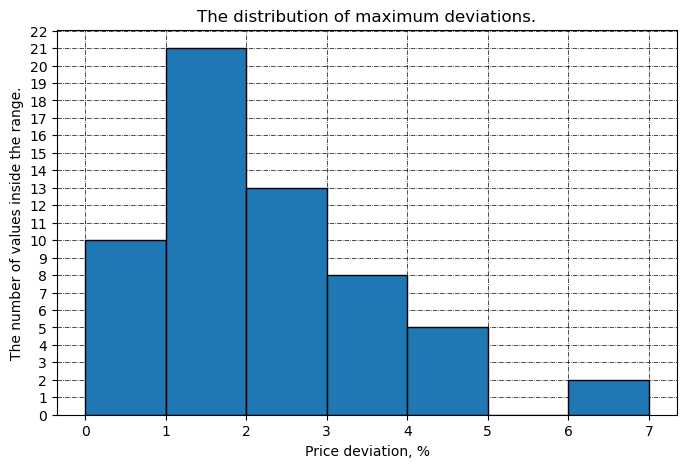

In [24]:
plot_hist(max_high_dif)

For minimums:

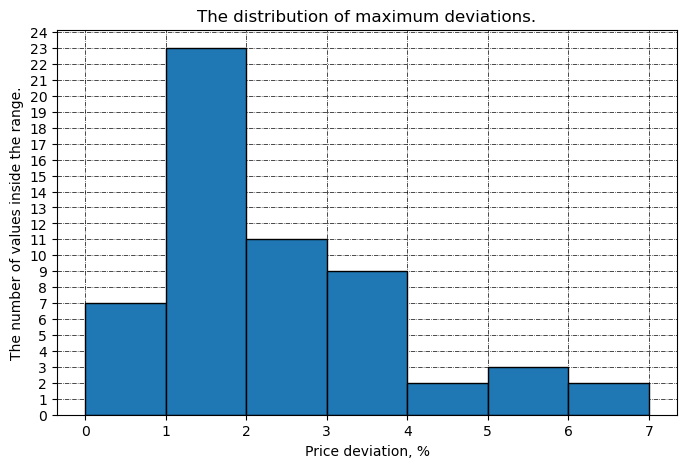

In [25]:
plot_hist(max_low_dif)

As we can see from the above charts the range between 1% and 2% has significantly more maximum values than other ranges. There are a lot of cases when the price deviation is more than 1%.

## Useful functions to create the charts and select "short" and "long" intervals

Create some functions that help us to select "short" and "long" intervals and create the chart for every weekend.
* A "short" interval is an intervals when the price deviation is above or equals threshold (>= 1%) and then the low price is below or equals zero (<= 0). 
* A "long" interval is an intervals when the price deviation is below or equals threshold (<= -1%) and then the high price is above or equals zero (>= 0). 

The detailed explanation can be found inside the functions.



plot_diff function:

In [26]:
def plot_diff(df):
    """ Plot the diffence between prices.
    
    Plot the difference between the close, high and low BTC prices on Binance and the close price on CME (hourly timeframe), %
    """
    dt_h = pd.to_timedelta(1, unit="H")
    fig, ax = plt.subplots(figsize=(18, 5))
    # Set the shift for the bars.
    shft = 0.1 * dt_h
    # Plot the bars.
    ax.bar(
        x=df.index - 2 * shft, 
        height=df["C_BI-C_CME%"],
        width=0.01,
        align="center",
        color="darkblue",
        zorder=2,
        label="C_BI-C_CME%"
    )
    
    ax.bar(
        x=df.index, 
        height=df["H_BI-C_CME%"],
        width=0.01,
        align="center",
        color="green",
        zorder=2,
        label="H_BI-C_CME%"
    )
    
    ax.bar(
        x=df.index + 2 * shft, 
        height=df["L_BI-C_CME%"],
        width=0.01,
        align="center",
        color="orange",
        zorder=2,
        label="L_BI-C_CME%"
    )
    # Set the locators.
    locator_mj = DayLocator()
    locator_mn = HourLocator()
    ax.xaxis.set_major_locator(locator_mj)  
    ax.xaxis.set_minor_locator(locator_mn)  
    # Set the formatters.
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))
    ax.xaxis.set_minor_formatter(DateFormatter("%H:%M"))
    # Set the tick parameters.    
    ax.xaxis.set_tick_params(which="both", rotation=90)
    # Set the axis labels and figure title.
    ax.set_title("The difference between the close, high, low BTC prices on Binance and the closing price on CME (hourly timeframe), %")
    ax.set_xlabel("DateTime, hours")
    ax.set_ylabel("The difference, %")    
    # Set the grids.
    ax.xaxis.grid(
        which="major", 
        color= "black", 
        linestyle="-.", 
        linewidth=0.5
    )
    ax.xaxis.grid(
        which="minor", 
        color= "black", 
        linestyle="dotted", 
        linewidth=0.5
    )
    ax.yaxis.grid(
        which="major", 
        color= "black", 
        linestyle="-.", 
        linewidth=0.5
    )
    # Set the legend.
    ax.legend()
    

get_short_intervals function:

In [27]:
def get_short_intervals(df: pd.DataFrame, th: int) -> tuple:
    """ Gets the the intervals for shorts.
    
    Helps to select the intervals for shorts.
    Select intervals when the high price delta is above or equals 
    threshold and then the low price is below or equals zero. 
    
    Args:
        df: The DataFrame.
        th: The threshold that start the interval (a positive value).
        
    Returns:
        intervals: The list of timestamp indexes. 
            The odd ones are starting points. 
            The even ones are end points.
        total_start_cnt: The total starts of intervals counter.
        ints_cnt: The interval counter.
    """
    # Prepare the data.
    df = df[1:-1]
    high_price_delta = df.loc[:, "H_BI-C_CME%"]
    low_price_delta = df.loc[:, "L_BI-C_CME%"].shift(-1)
    # Set flags and initial conditions.
    outside: bool = True
    end1: bool = False
    end2: bool = False
    intervals: list = []
    last_idx = df.index[-1]
    start_cnt = 0
    ints_cnt = 0
    total_start_cnt = 0
    # Go through all bars.
    for index, row in df.iterrows():
        # It compensates index shift for low price delta and helps to print
        # the correct index.
        if end1:
            end1 = False
            logger.debug(f"Stop the interval: {index}")  
            intervals.append(index)  
        elif end2:
            end2 = False
            logger.debug(f"Stop the interval (start-stop adjacent bars): {index}")      
            intervals.append(index)
        # The high price delta < threshold and outside interval. 
        # Change nothing. Continue outside interval.
        if high_price_delta[index] < th and outside == True:
            logger.debug(f"Outside an interval: {index}")
            # print(f"Outside an interval: {index}")
        # Inside interval and the low price delta > 0.
        # Change nothing. Continue inside interval.
        elif outside == False and low_price_delta[index] > 0:
            logger.debug(f"Inside the interval: {index}")
        # Inside interval and the low price delta < 0.
        # The end of the interval. 
        elif outside == False and low_price_delta[index] < 0:
            outside = True
            end1 = True
            logger.debug(f"The last bar before stopping the interval: {index}")  
        # The high price delta >= threshold, outside interval, and the low price delta > 0.
        # Start the interval.
        elif high_price_delta[index] >= th and outside == True and low_price_delta[index] >= 0:
            outside = False
            logger.debug(f"Start the interval: {index}")
            intervals.append(index)
            # Count how many times the intervals start.
            start_cnt += 1
        # The high price delta >= threshold, outside interval, and the low price delta < 0.
        # Start the interval and stop the interval (the adjacent bars have conditions to start and
        # stop at once).
        elif high_price_delta[index] >= th and outside == True and (low_price_delta[index] <= 0 or np.isnan(low_price_delta[index])):
            end2 = True
            logger.debug(f"Start the interval (start-stop adjacent bars): {index}")   
            intervals.append(index)
            # Count how many times the intervals start.
            start_cnt += 1
        # No appropriate intervals for conditions.
        # elif index == last_idx and len(intervals) % 2 != 0:
        elif len(intervals) % 2 != 0:
            logger.debug(f"No appropriate conditions for the last interval or no intervals at all: {index}")
        else:
            logger.warning(f"Unpredictable behaviour: {index}")
        # Count full intervals (start and stop)
    total_start_cnt = start_cnt
    ints_cnt += len(intervals) // 2
    # print(total_start_cnt, ints_cnt)
    return intervals, total_start_cnt, ints_cnt

get_long_intervals function:

In [28]:
def get_long_intervals(df: pd.DataFrame, th: int) -> tuple:
    """ Gets the the intervals for longs.
    
    Helps to select the intervals for longs.
    Select intervals when the low price delta is below or equals 
    threshold and then the high price is above or equals zero. 
    
    Args:
        df: The DataFrame.
        th: The threshold that start the interval (a negative value).
        
    Returns:
        intervals: The list of timestamp indexes. 
            The odd ones are starting points. 
            The even ones are end points.
        total_start_cnt: The total starts of intervals counter.
        ints_cnt: The interval counter.
    """
    # Prepare the data.
    df = df[1:-1]
    low_price_delta = df.loc[:, "L_BI-C_CME%"]
    high_price_delta = df.loc[:, "H_BI-C_CME%"].shift(-1)
    # Set flags and initial conditions.
    outside: bool = True
    end1: bool = False
    end2: bool = False
    intervals: list = []
    last_idx = df.index[-1]
    start_cnt = 0
    ints_cnt = 0
    total_start_cnt = 0
    # Go through all bars.
    for index, row in df.iterrows():
        # It compensates index shift for low price delta and helps to print
        # the correct index.
        if end1:
            end1 = False
            logger.debug(f"Stop the interval: {index}")  
            intervals.append(index)  
        elif end2:
            end2 = False
            logger.debug(f"Stop the interval (start-stop adjacent bars): {index}")      
            intervals.append(index)
        # The high price delta < threshold and outside interval. 
        # Change nothing. Continue outside interval.
        if low_price_delta[index] > th and outside == True:
            logger.debug(f"Outside an interval: {index}")
            # print(f"Outside an interval: {index}")
        # Inside interval and the low price delta > 0.
        # Change nothing. Continue inside interval.
        elif outside == False and high_price_delta[index] < 0:
            logger.debug(f"Inside the interval: {index}")
        # Inside interval and the low price delta < 0.
        # The end of the interval. 
        elif outside == False and high_price_delta[index] > 0:
            outside = True
            end1 = True
            logger.debug(f"The last bar before stopping the interval: {index}")  
        # The high price delta >= threshold, outside interval, and the low price delta > 0.
        # Start the interval.
        elif low_price_delta[index] <= th and outside == True and high_price_delta[index] <= 0:
            outside = False
            logger.debug(f"Start the interval: {index}")
            intervals.append(index)
            # Count how many times the intervals start.
            start_cnt += 1
        # The high price delta >= threshold, outside interval, and the low price delta < 0.
        # Start the interval and stop the interval (the adjacent bars have conditions to start and
        # stop at once).
        elif low_price_delta[index] <= th and outside == True and (high_price_delta[index] >= 0 or np.isnan(high_price_delta[index])):
            end2 = True
            logger.debug(f"Start the interval (start-stop adjacent bars): {index}")   
            intervals.append(index)
            # Count how many times the intervals start.
            start_cnt += 1
        # No appropriate intervals for conditions.
        # elif index == last_idx and len(intervals) % 2 != 0:
        elif len(intervals) % 2 != 0:
            logger.debug(f"No appropriate conditions for the last interval or no intervals at all: {index}")
        else:
            logger.warning(f"Unpredictable behaviour: {index}")
        # Count full intervals (start and stop)
    total_start_cnt = start_cnt
    ints_cnt += len(intervals) // 2
    # print(total_start_cnt, ints_cnt)
    return intervals, total_start_cnt, ints_cnt

## Create the chart of price deviatons for every weekend

The charts shows for every weekend (hourly timeframe):
* C_BI-C_CME% - The difference between the closing prices on Binance and CME, %
* H_BI-C_CME% - The difference between the high price on Binance and the closing price on CME, %
* L_BI-C_CME% - The difference between the low price on Binance and the closing price on CME, %

/var/folders/gh/mx3xbl0d69jftpptc8yn6mn40000gn/T/ipykernel_95405/3698212533.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(18, 5))


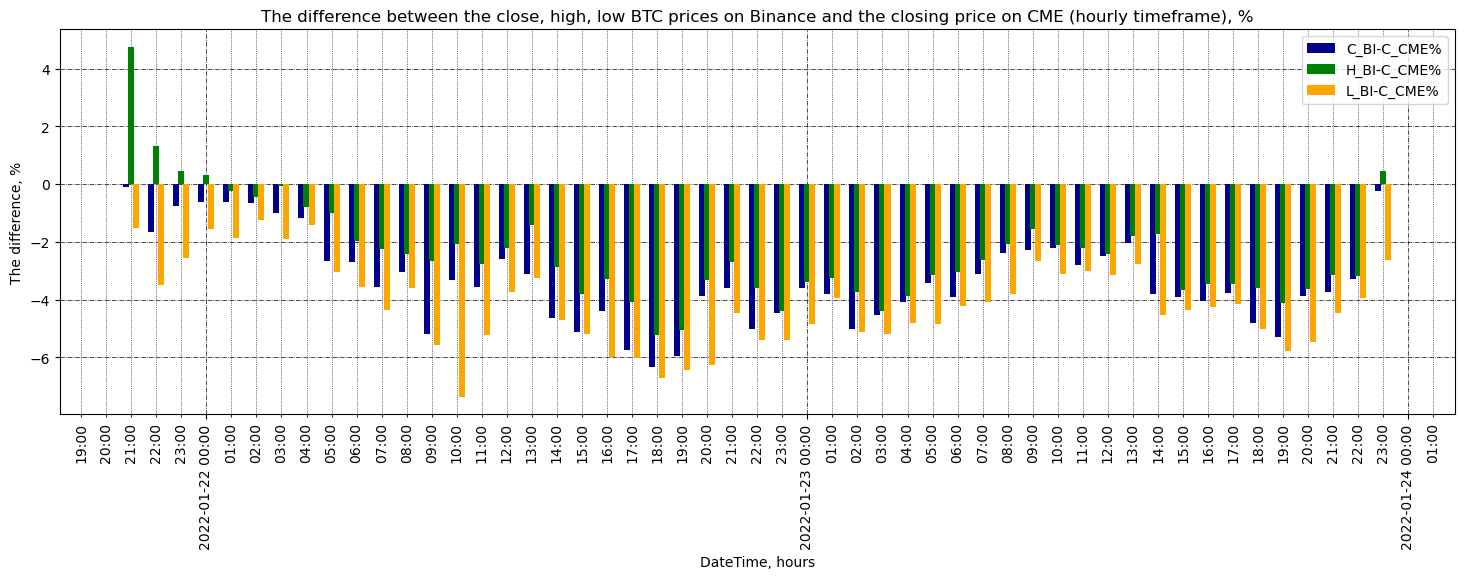

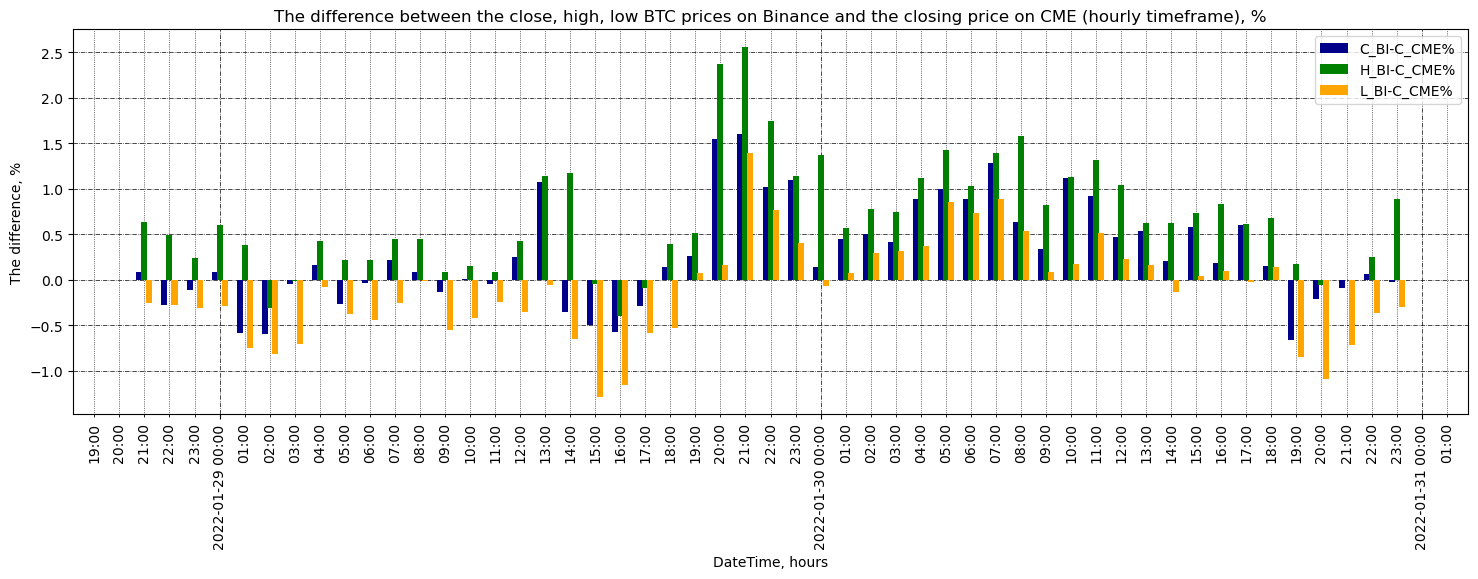

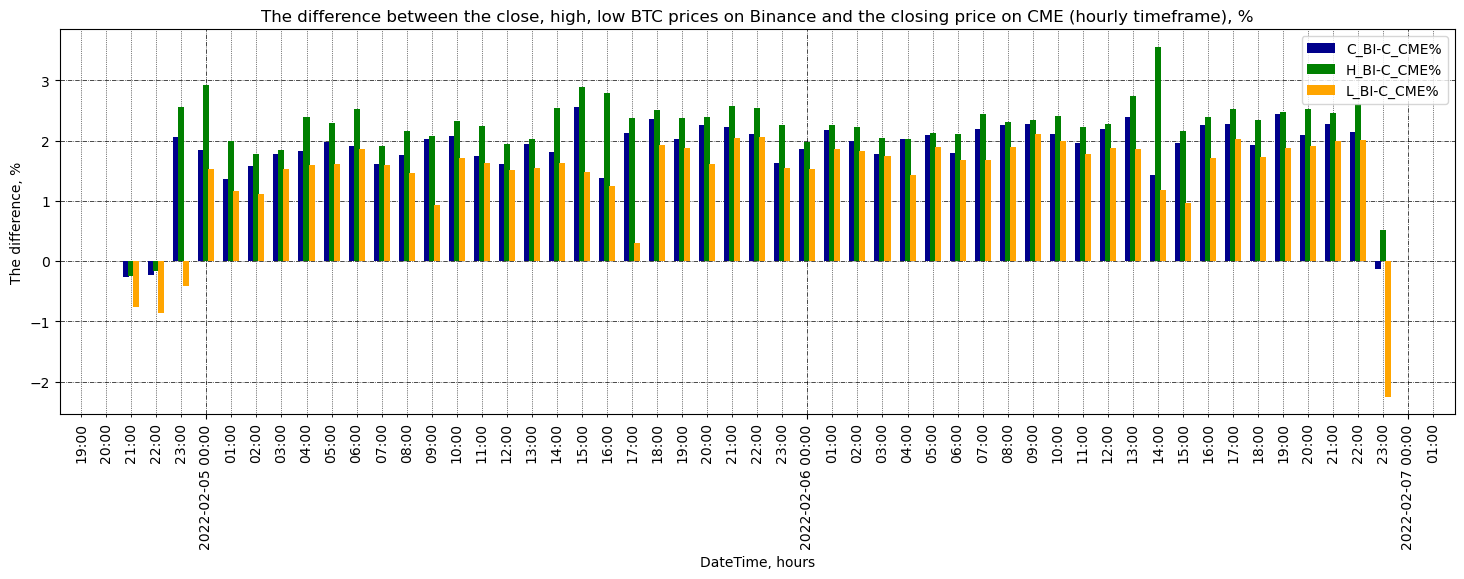

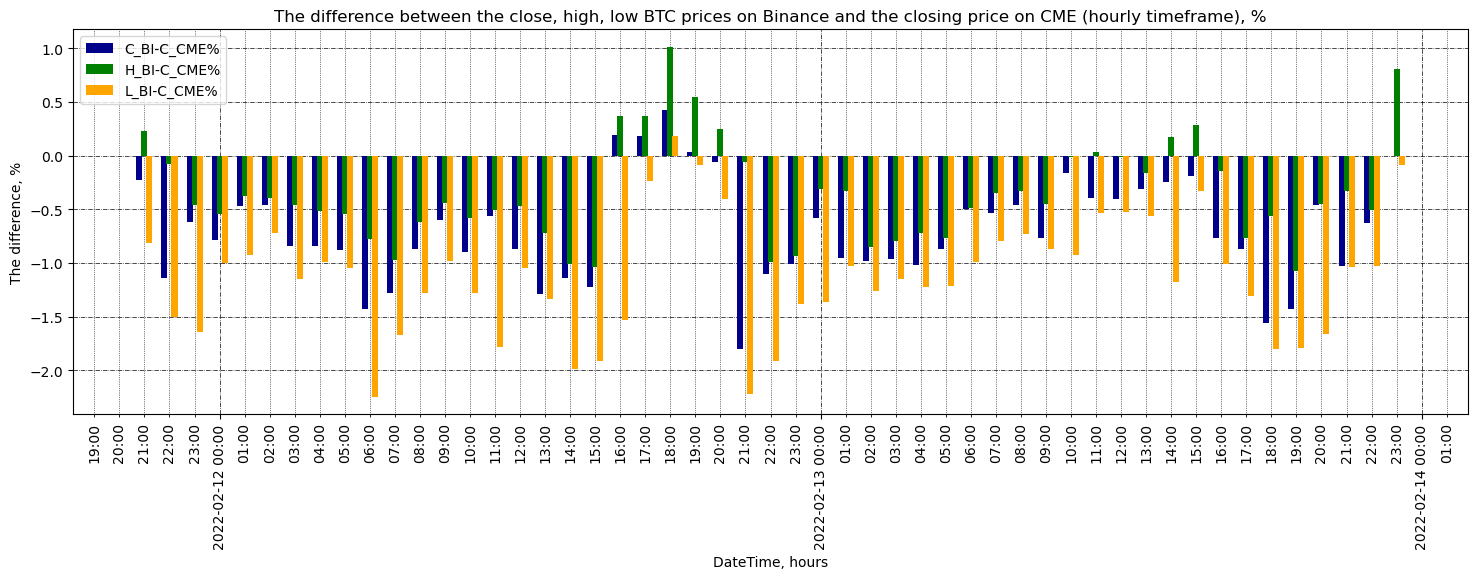

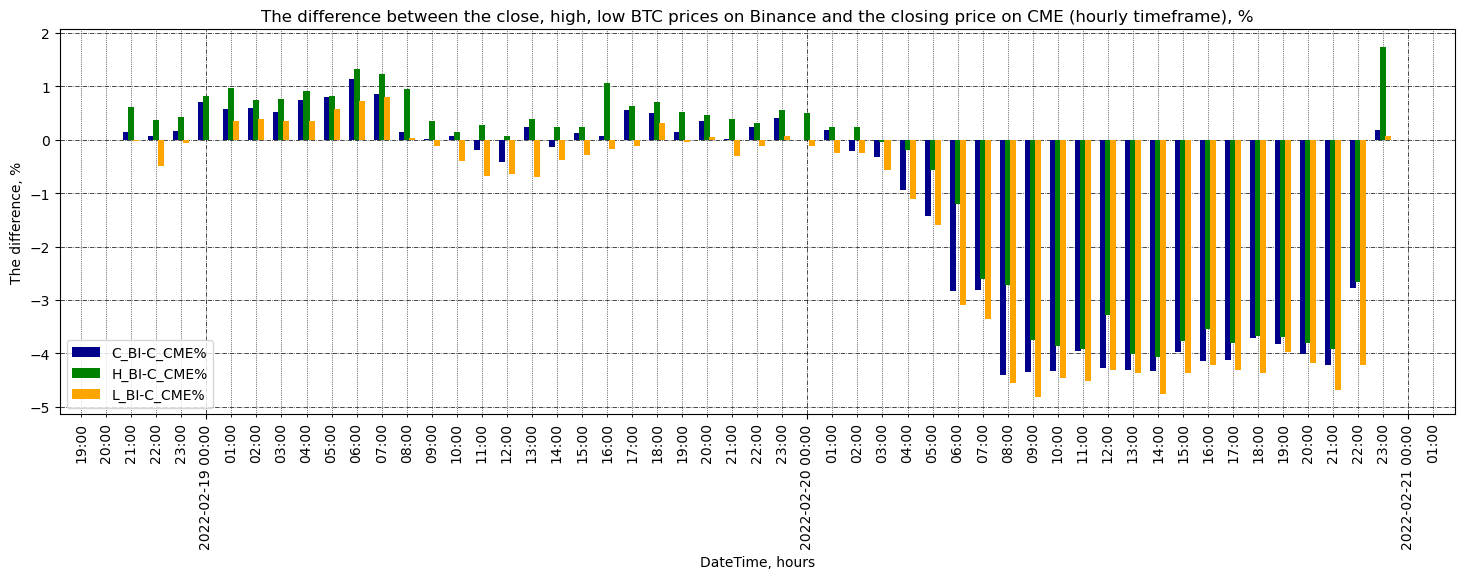

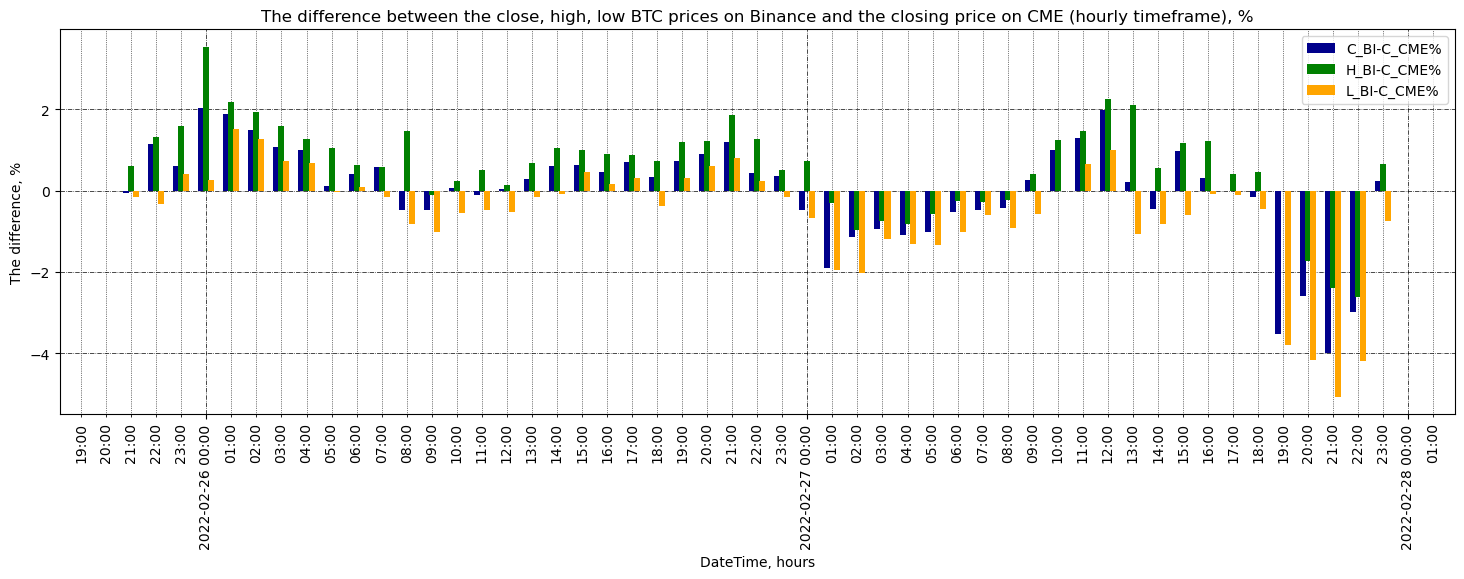

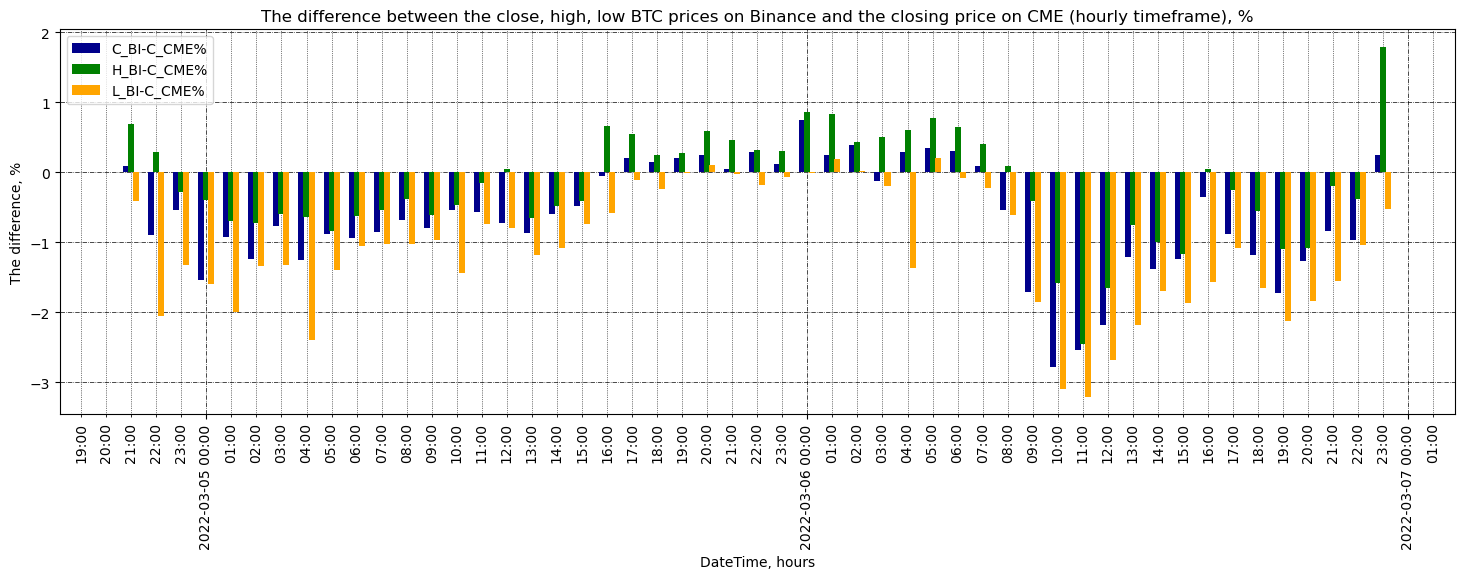

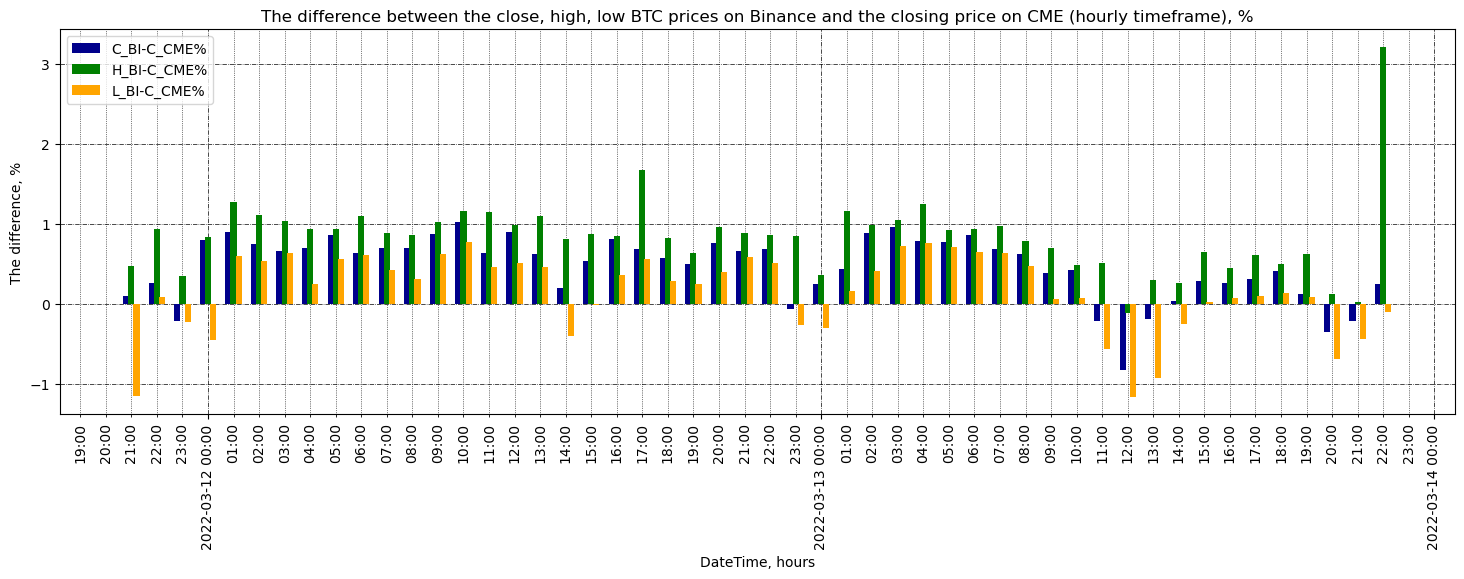

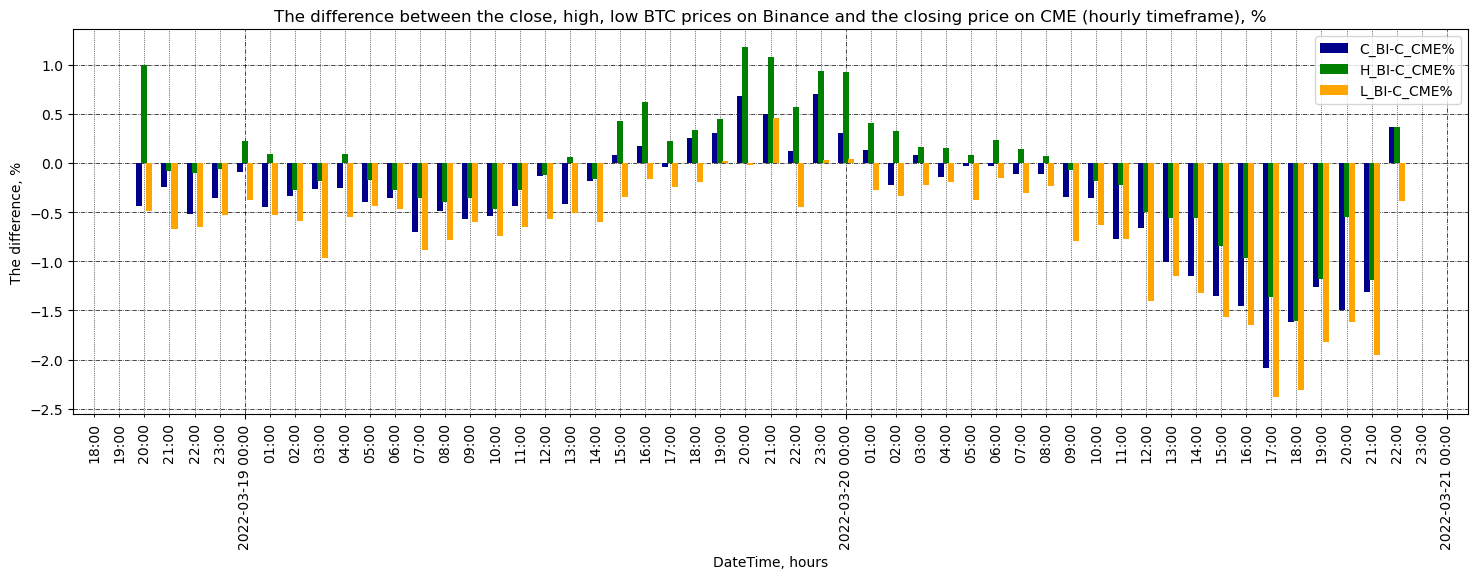

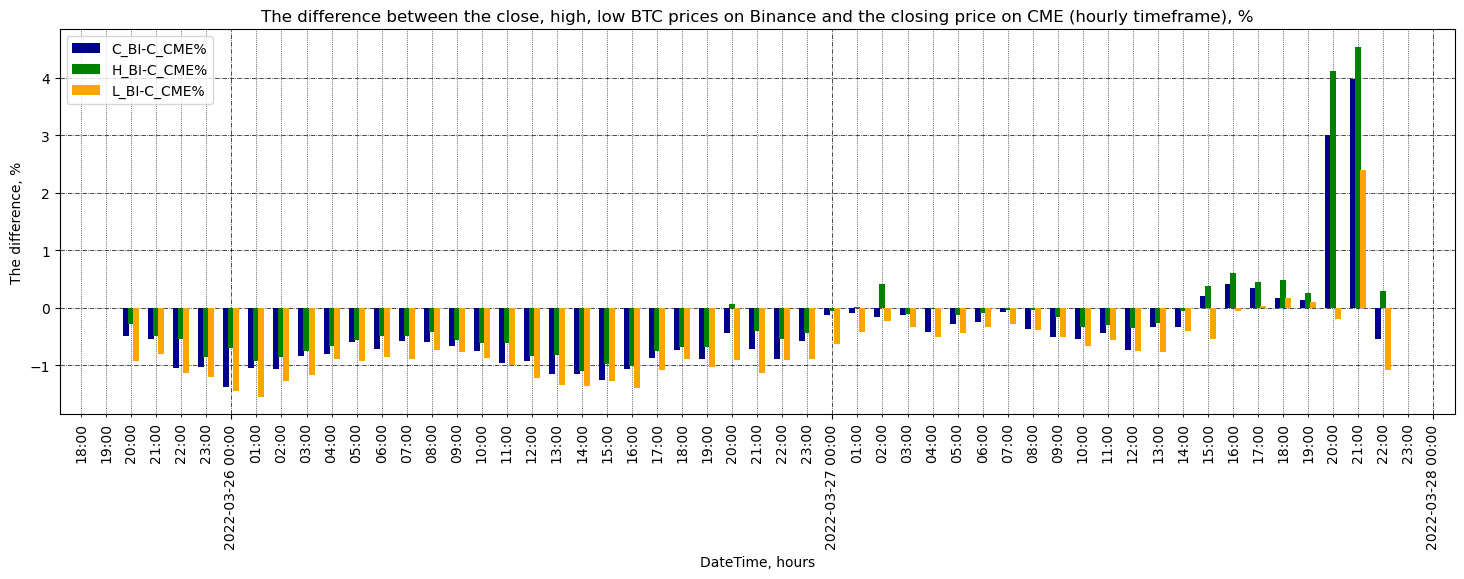

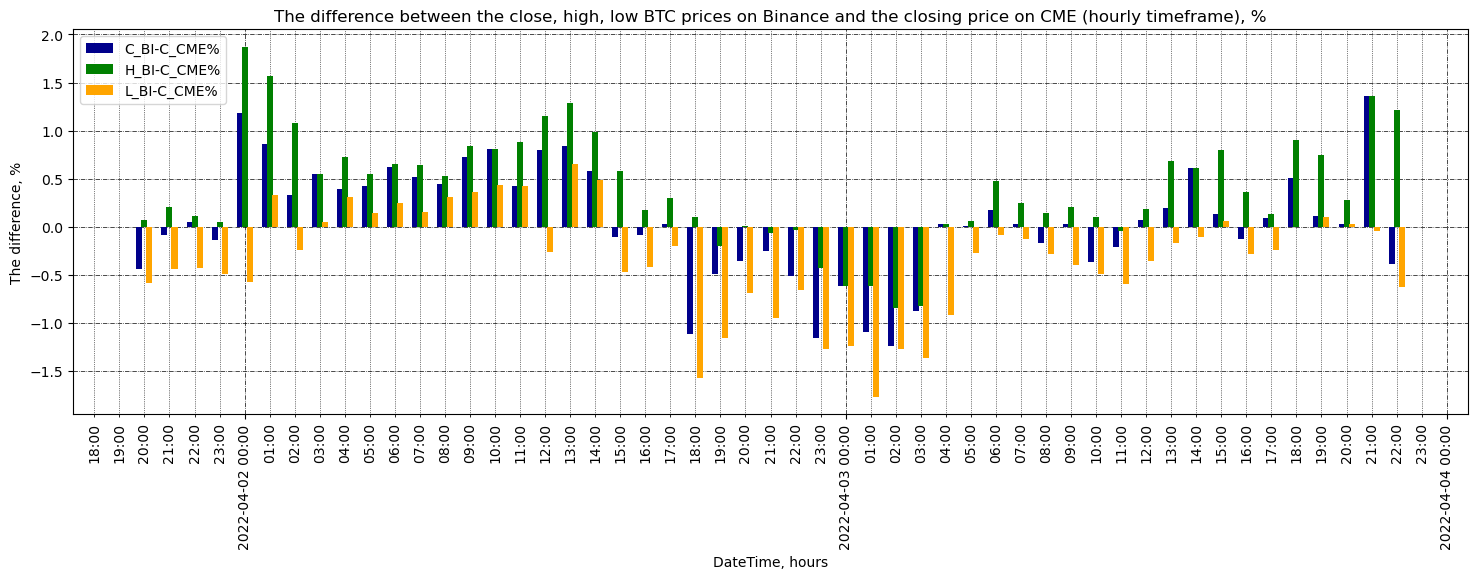

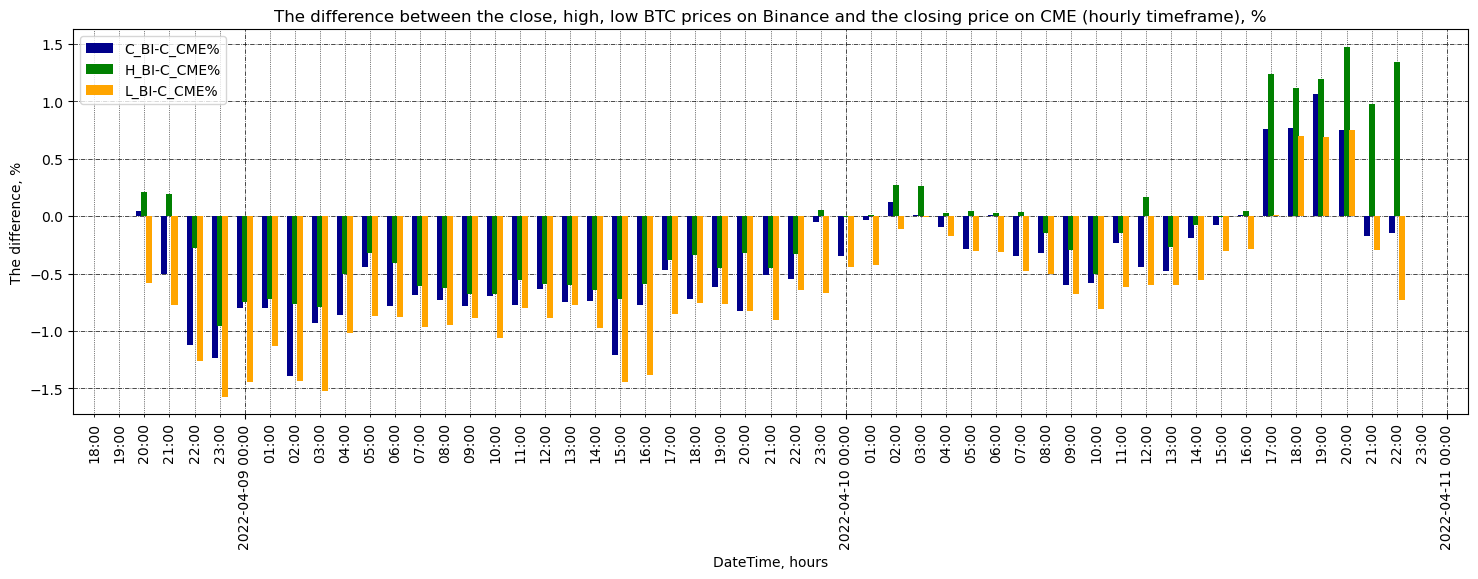

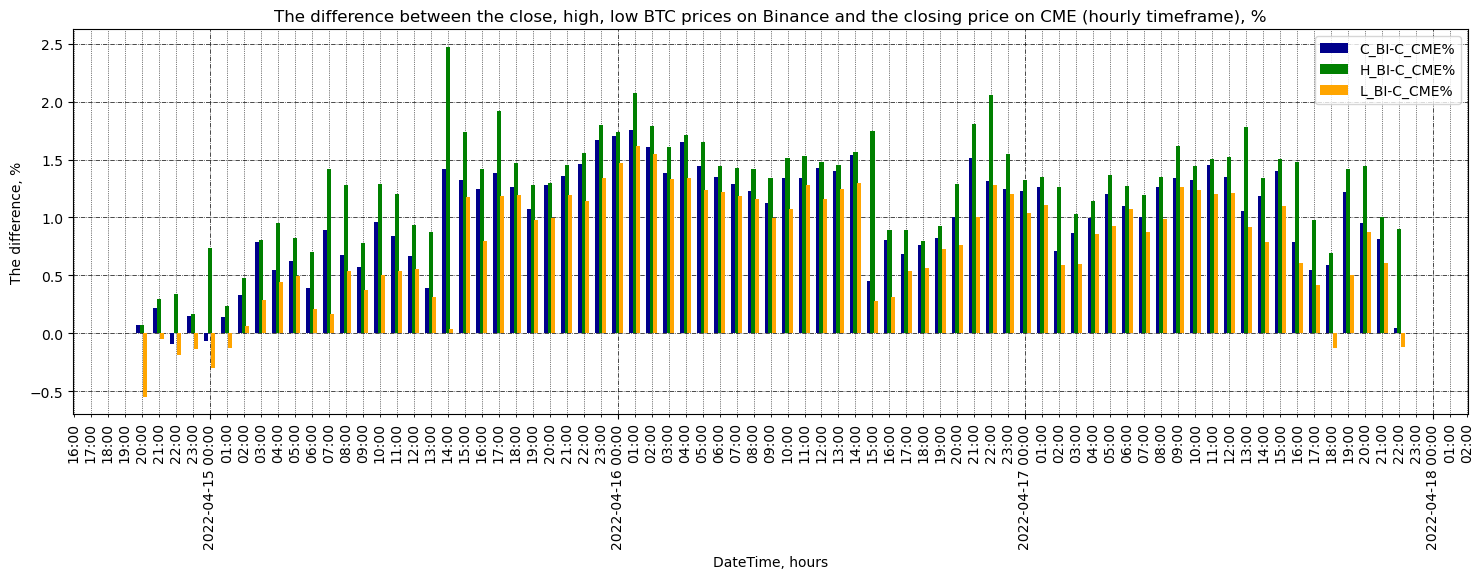

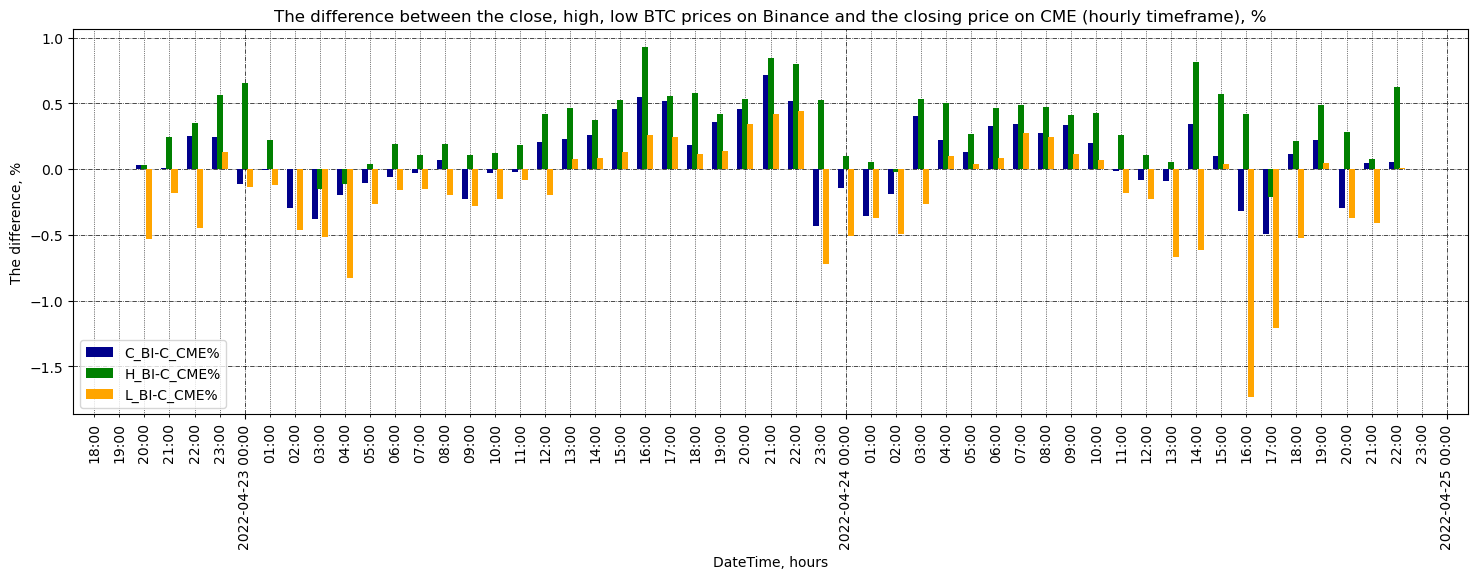

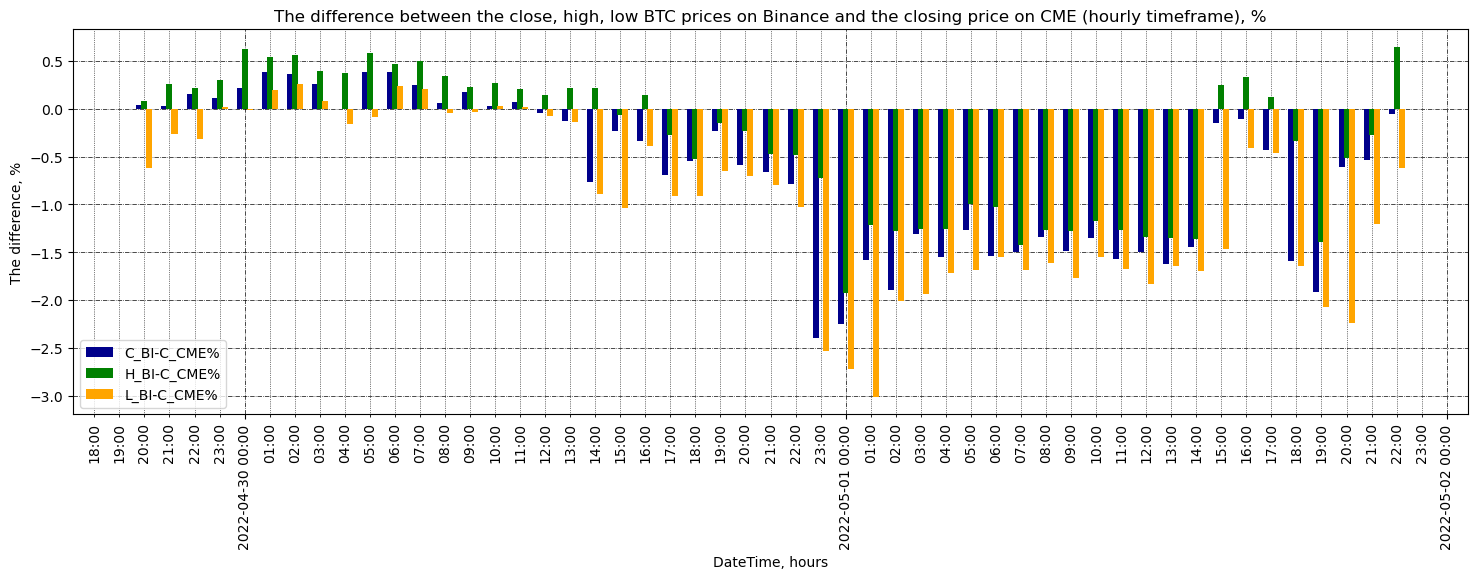

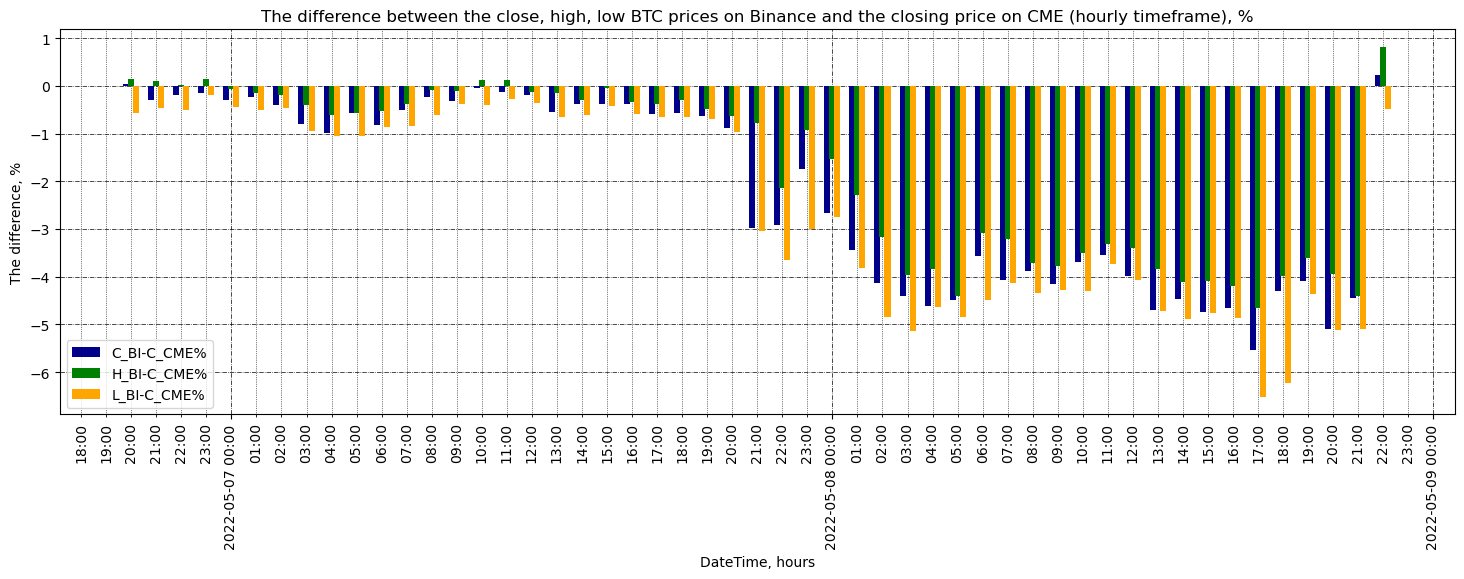

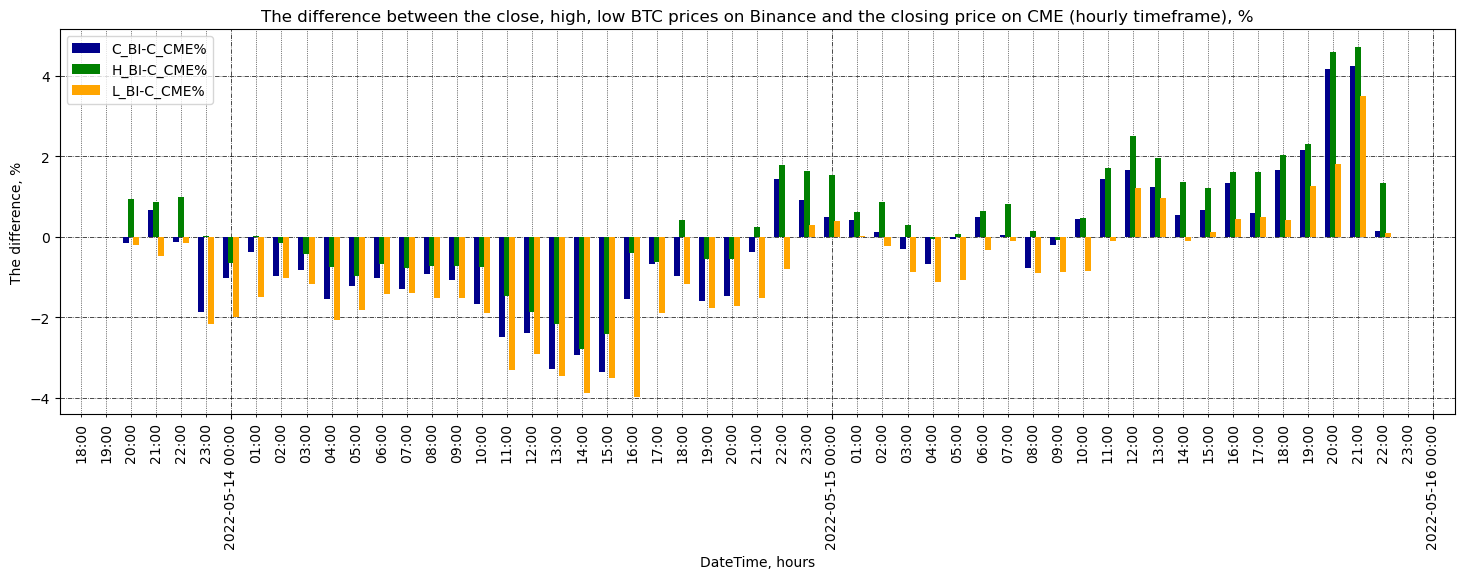

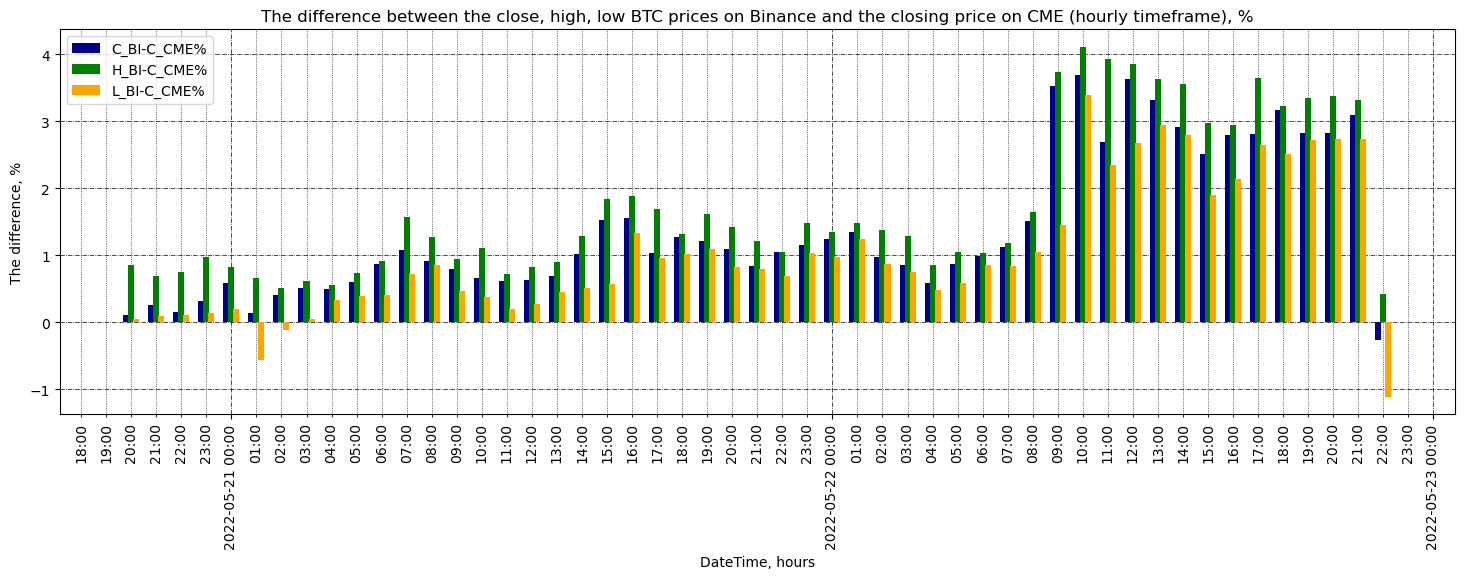

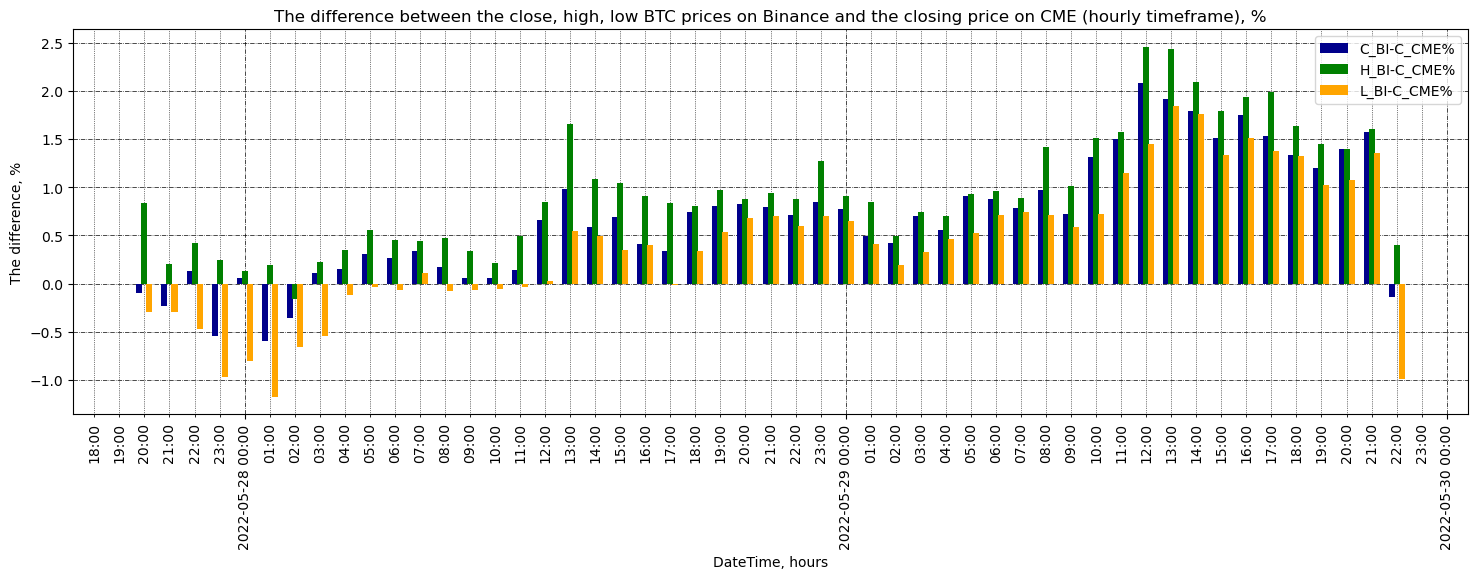

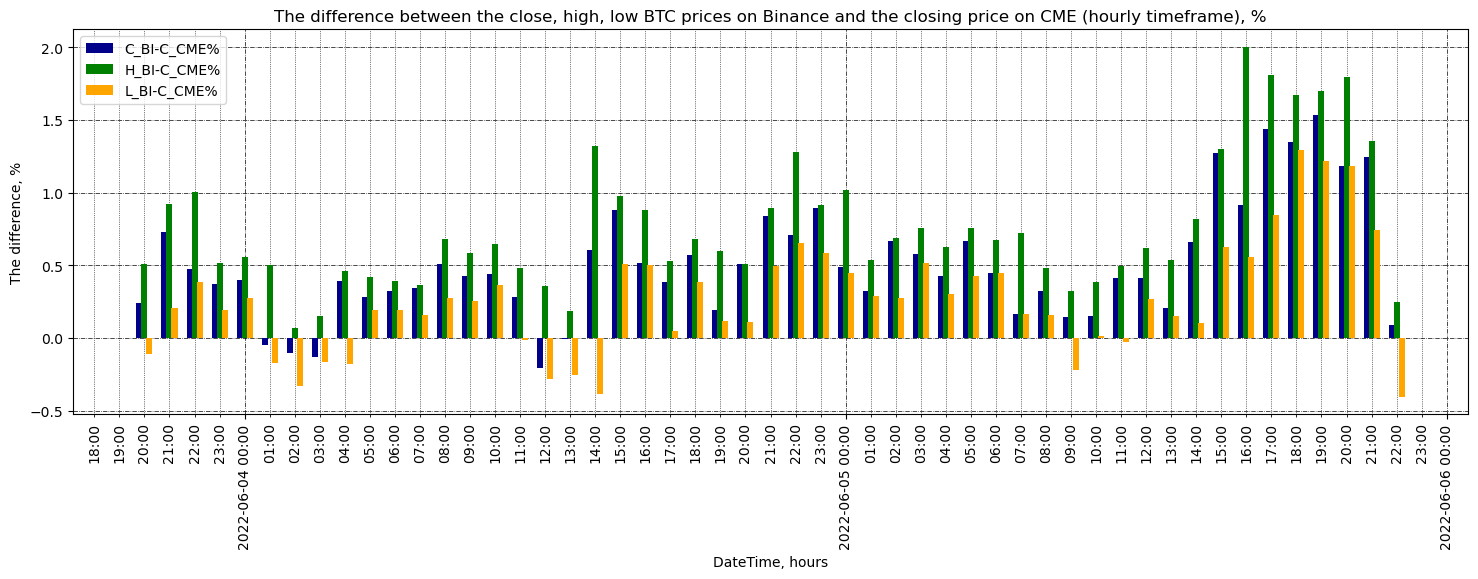

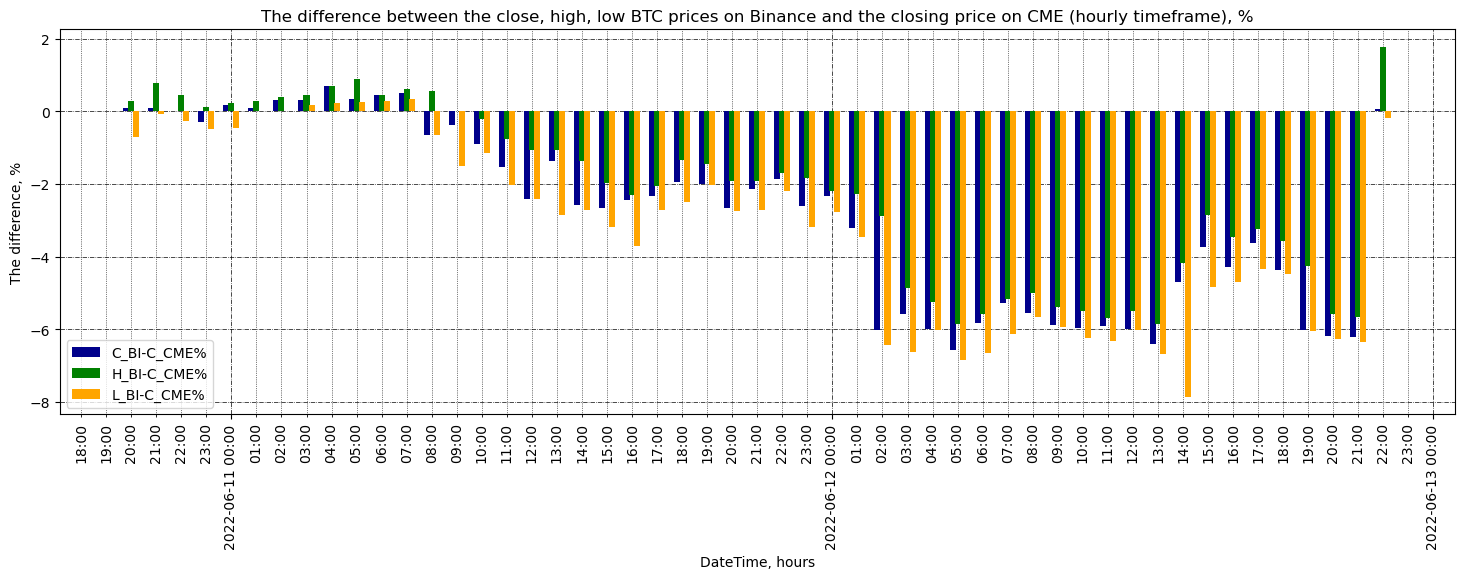

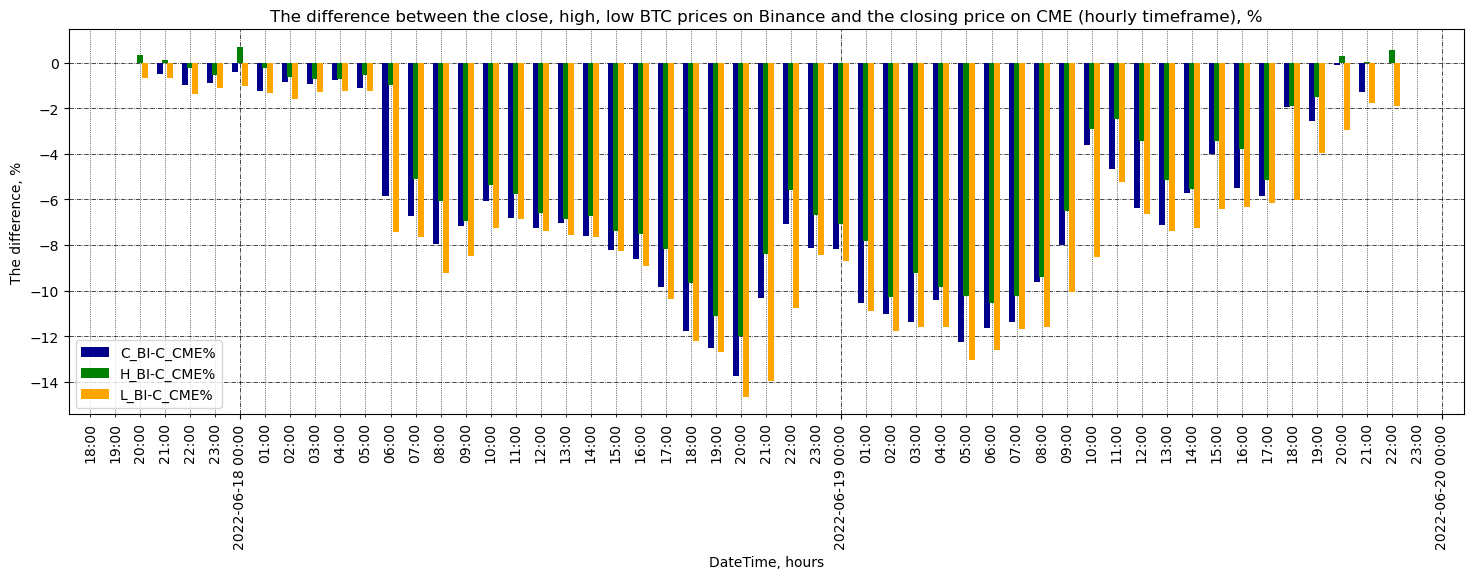

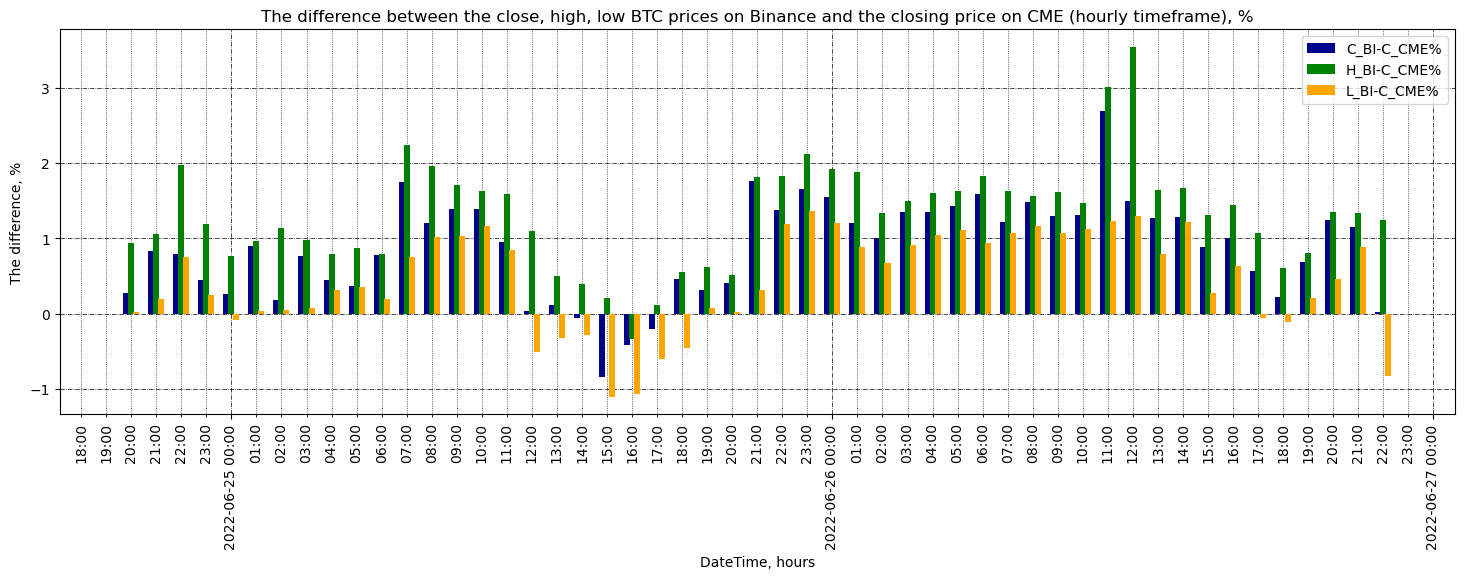

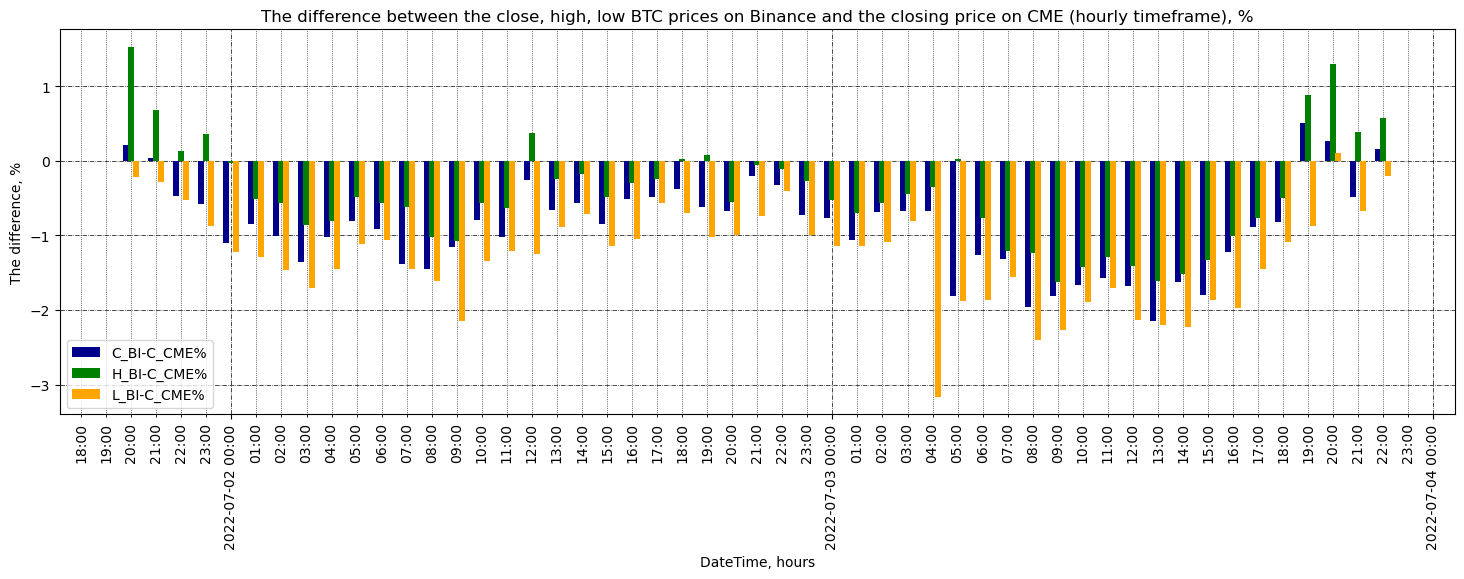

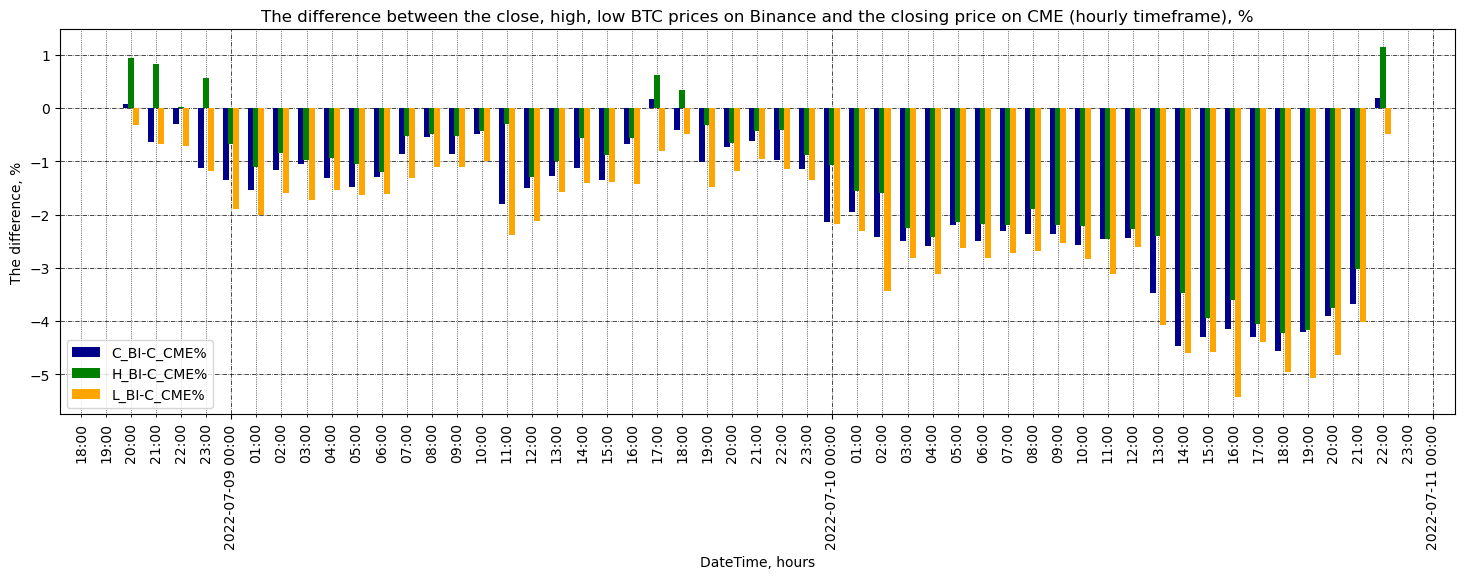

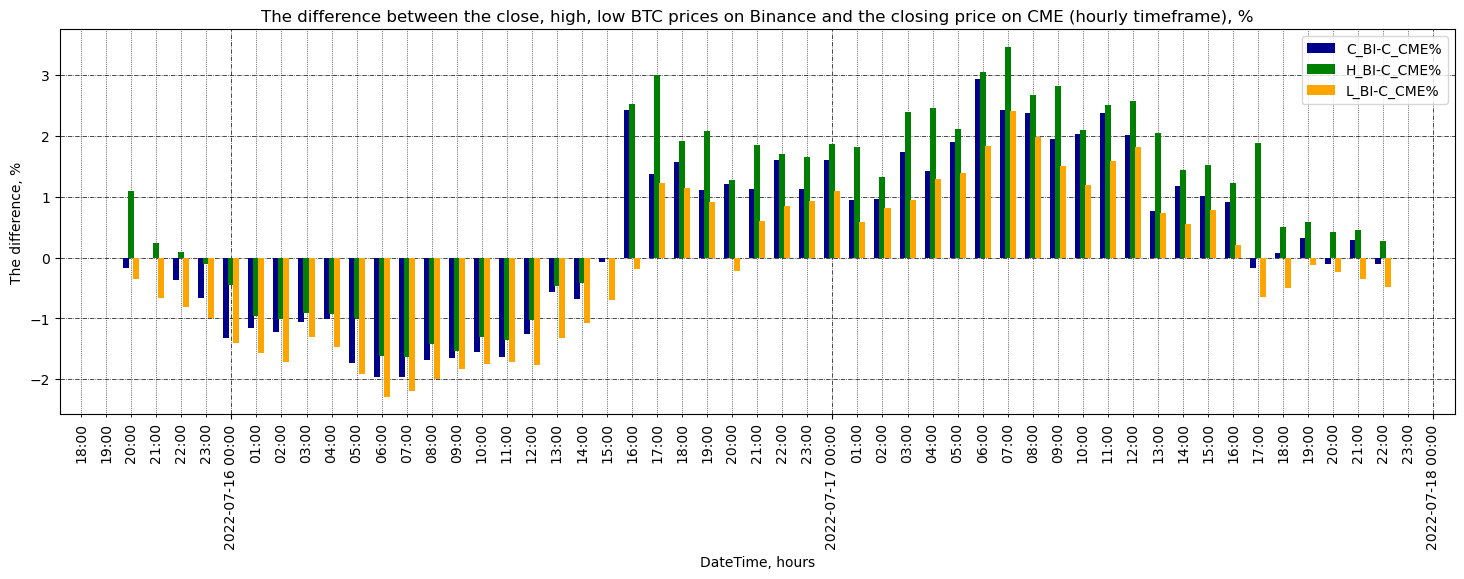

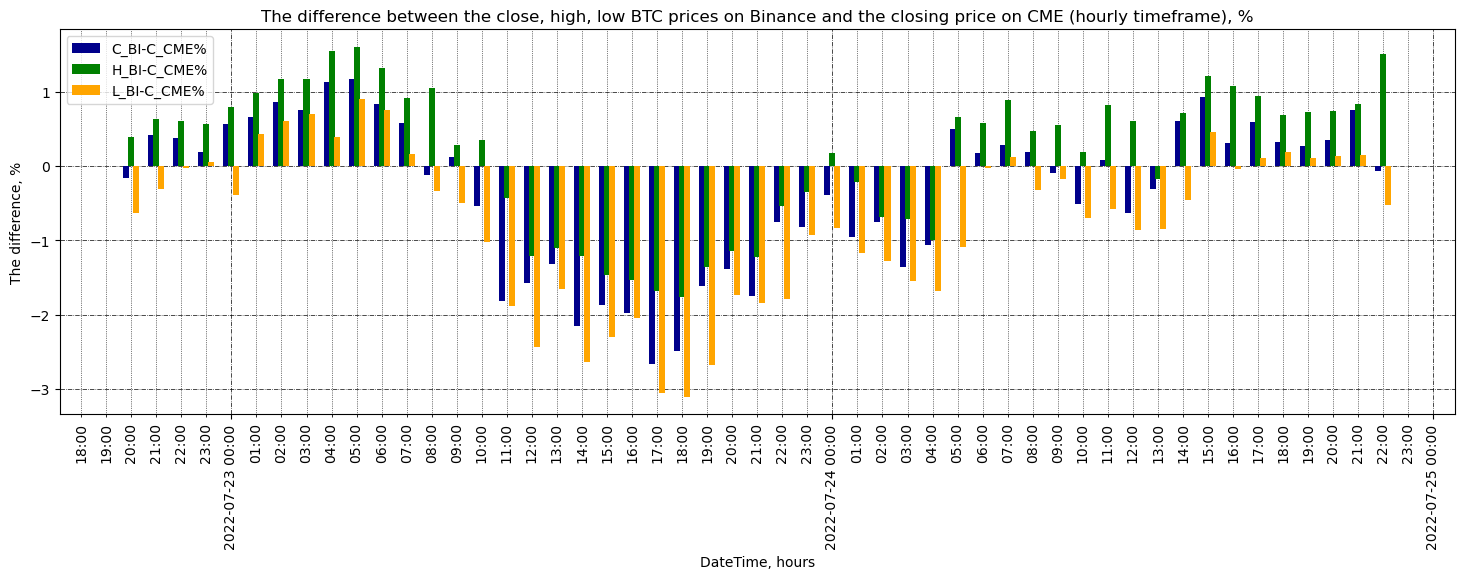

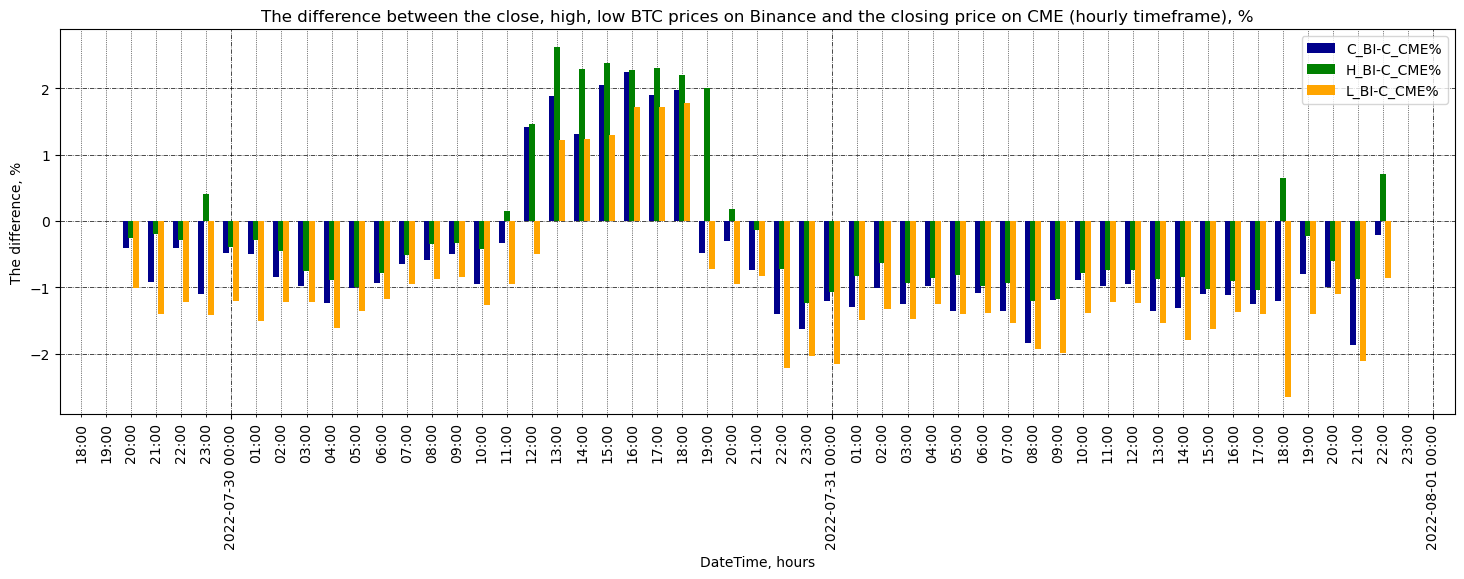

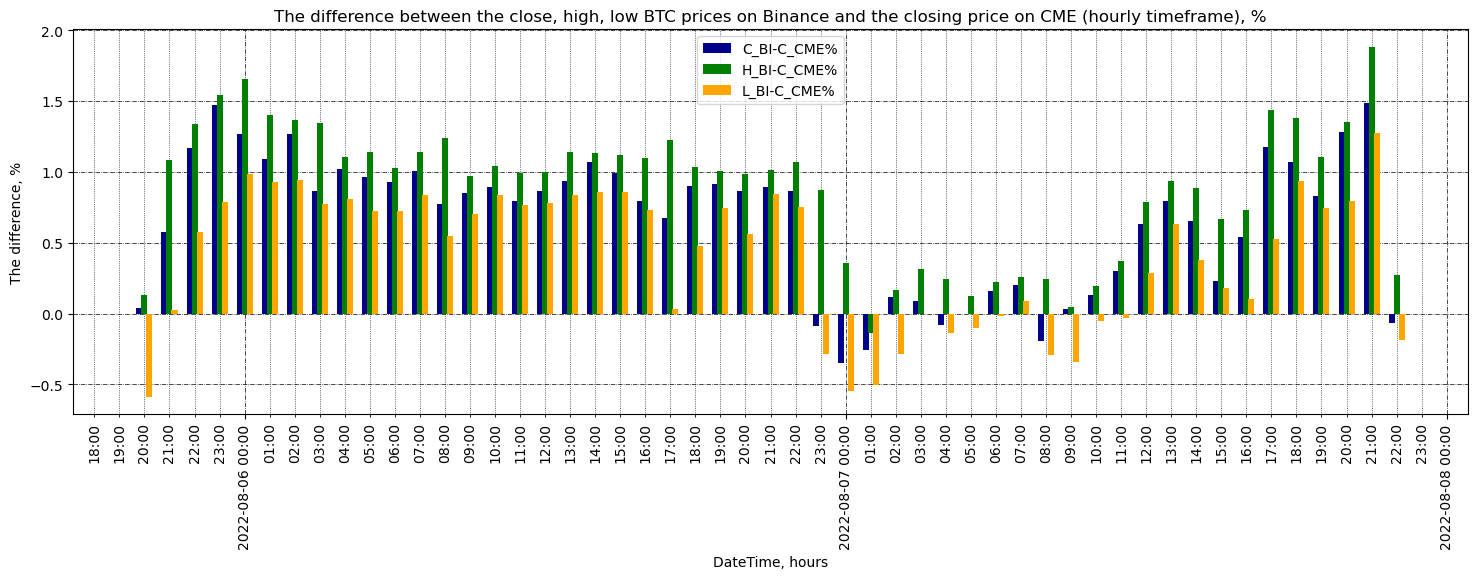

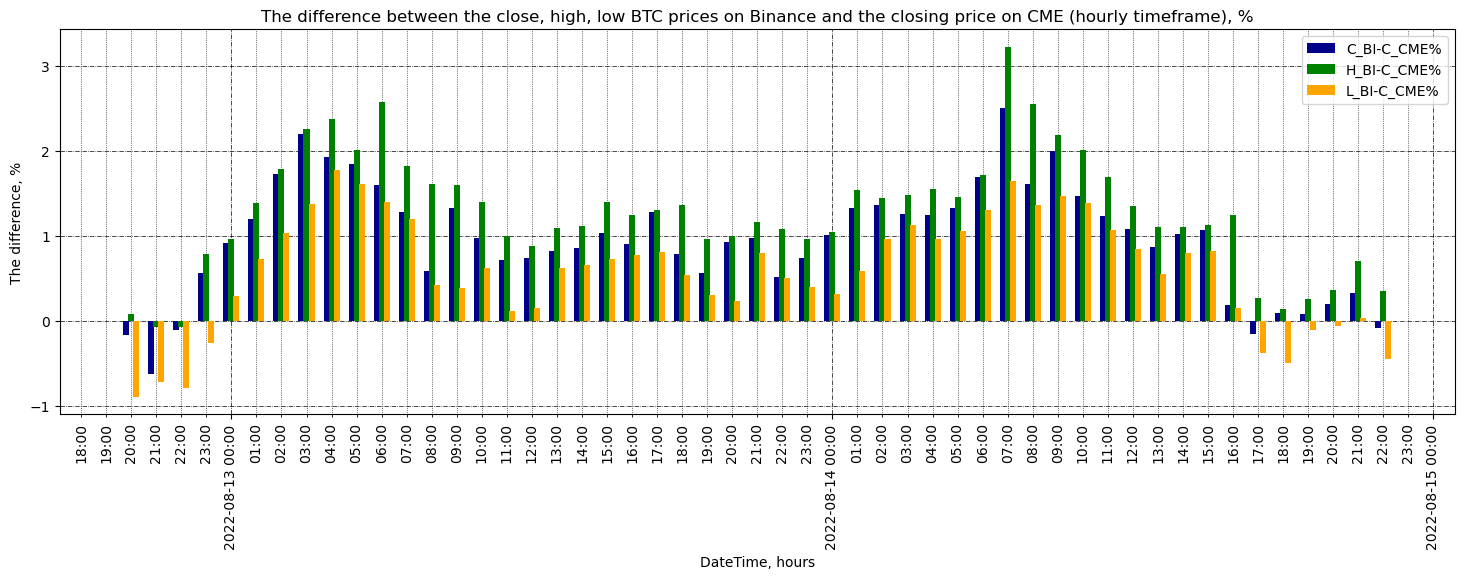

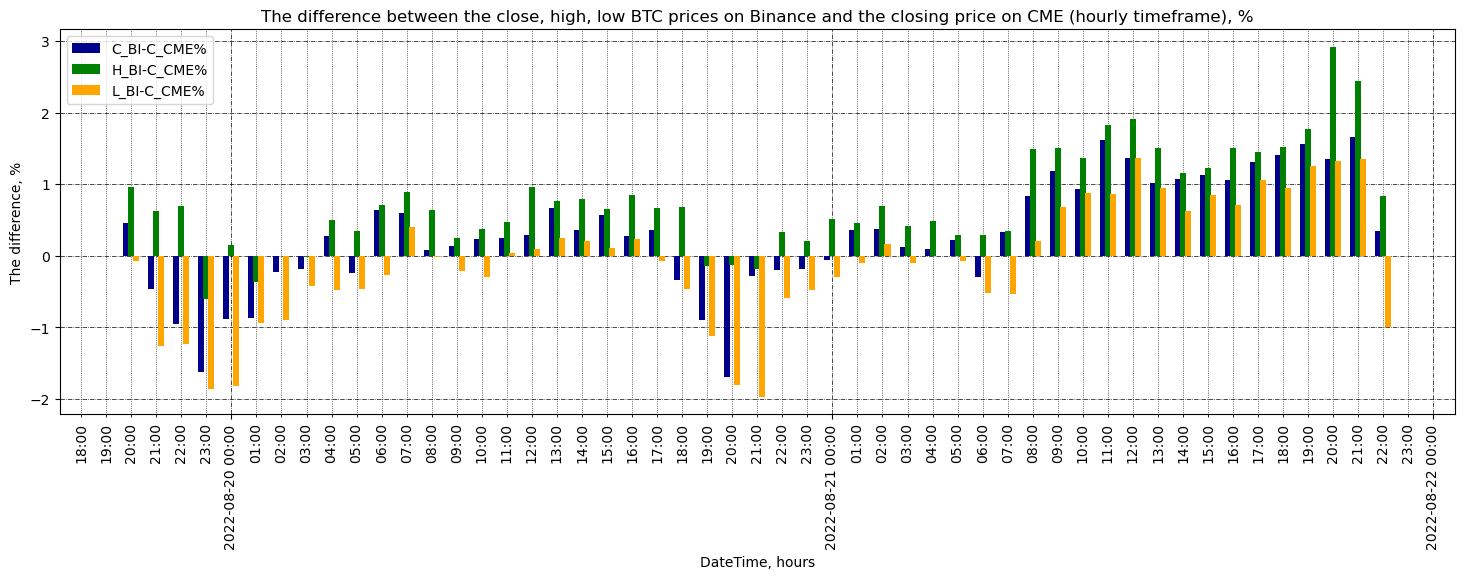

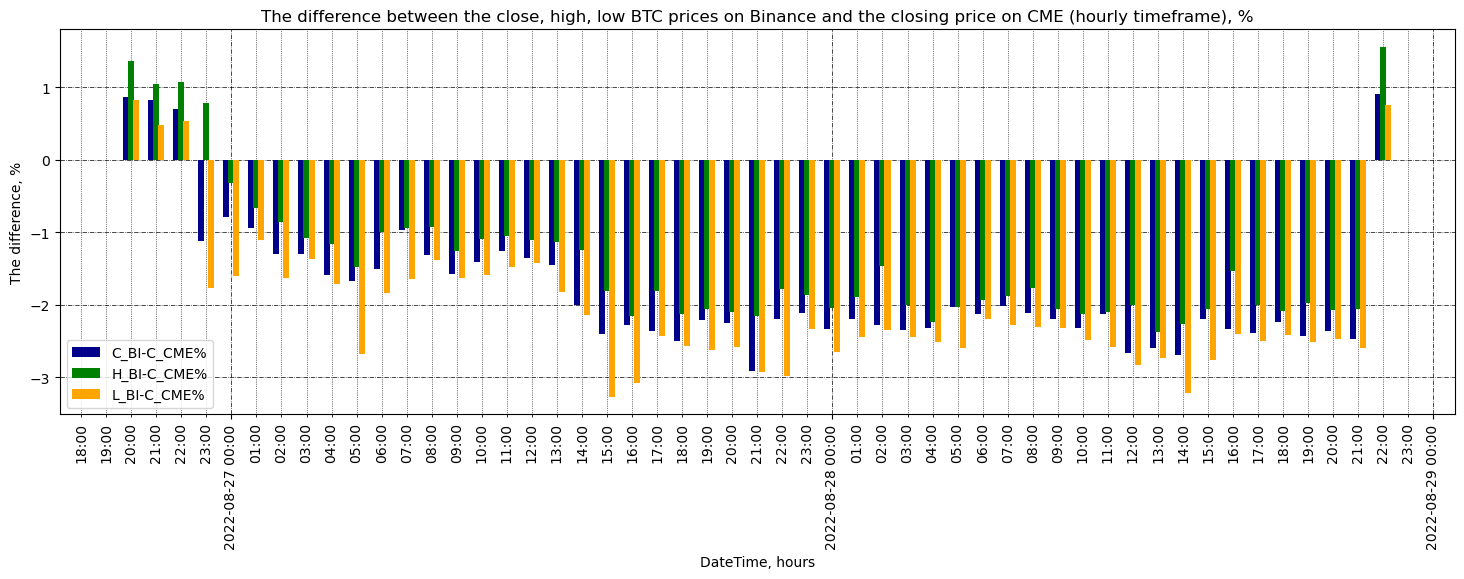

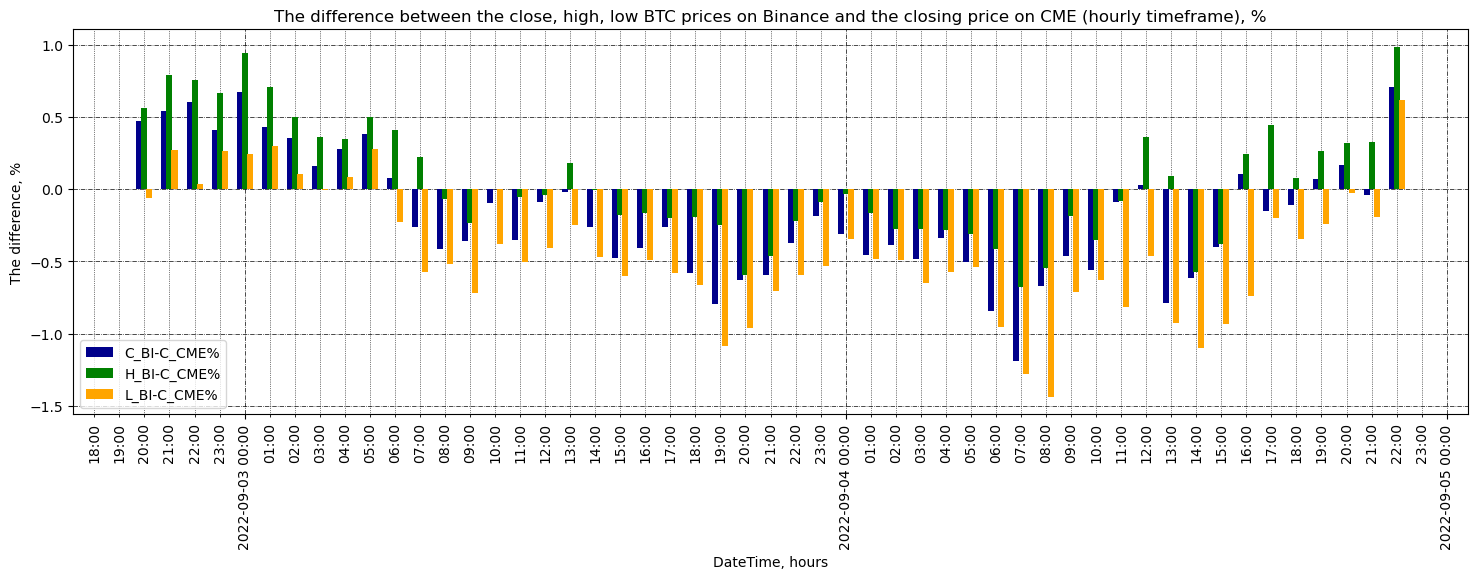

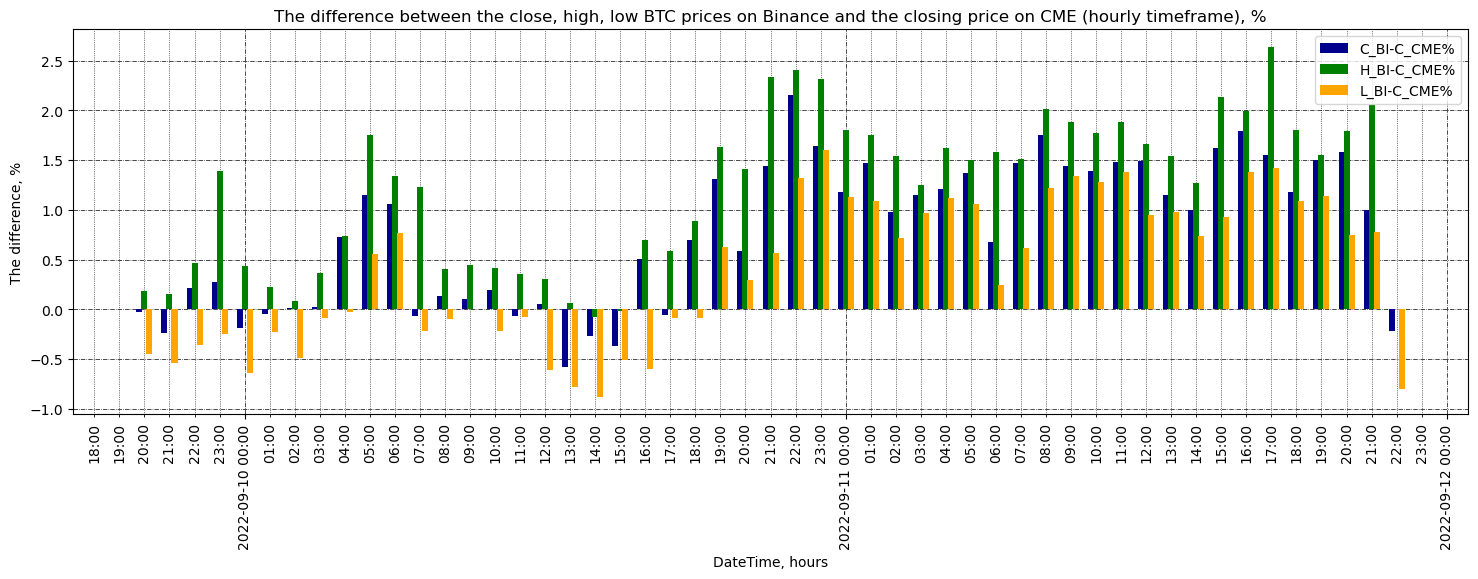

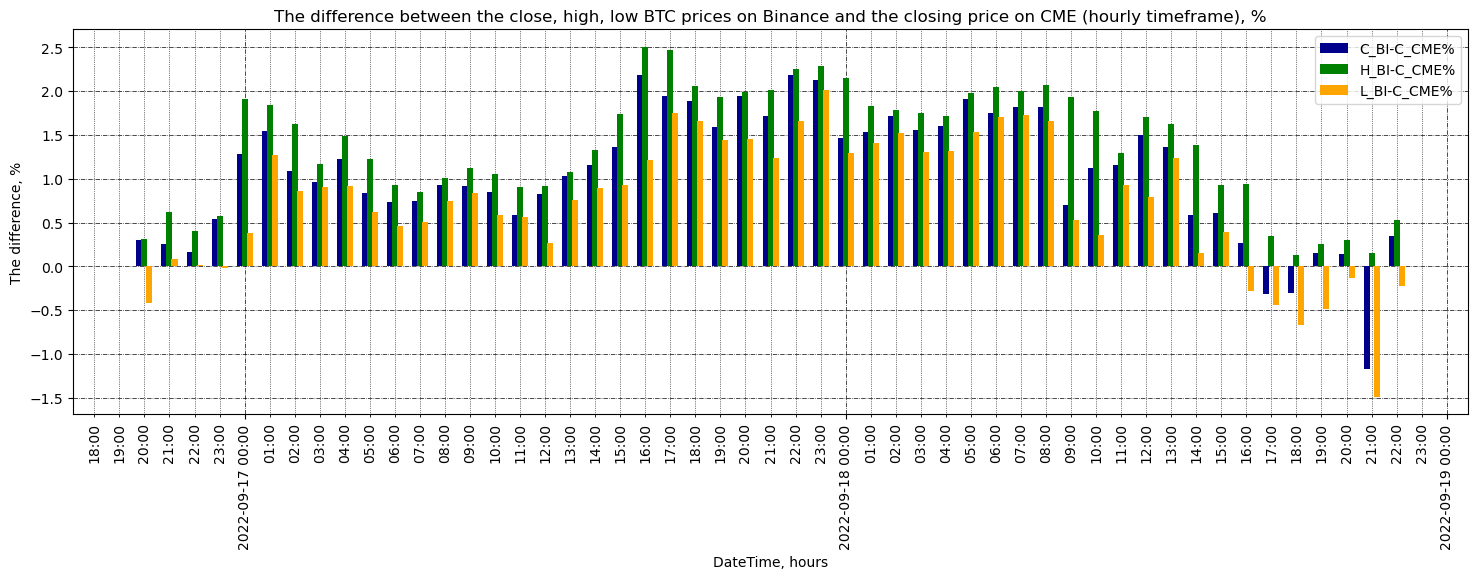

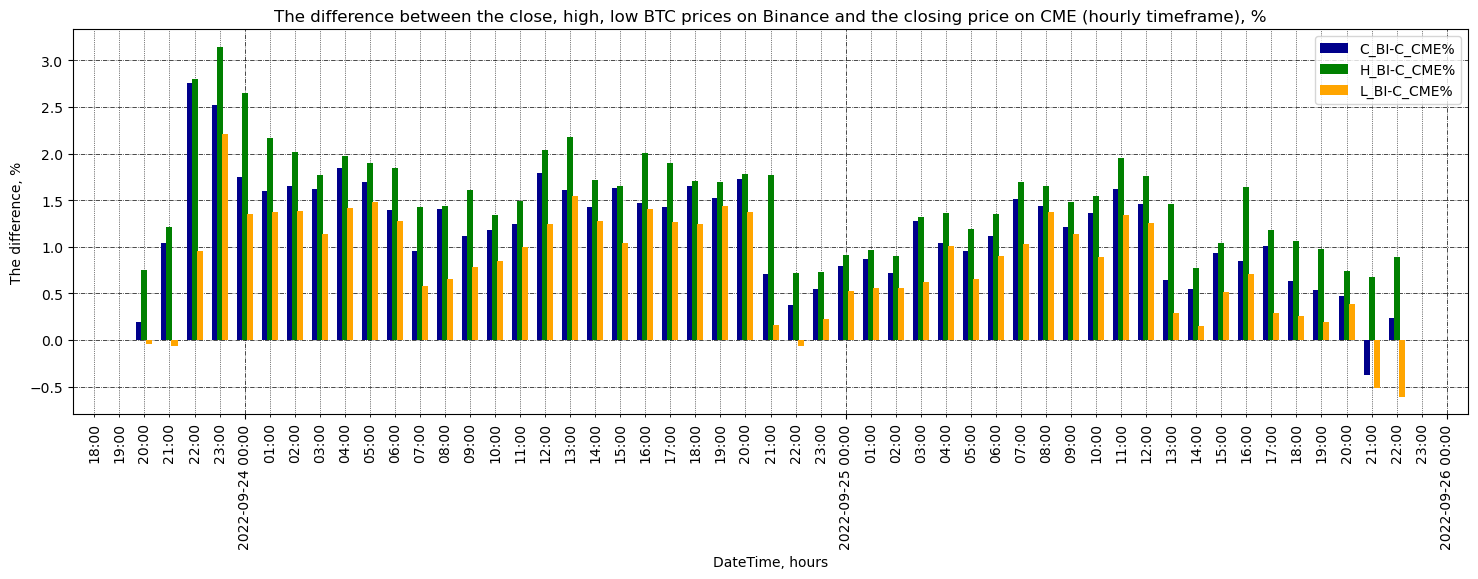

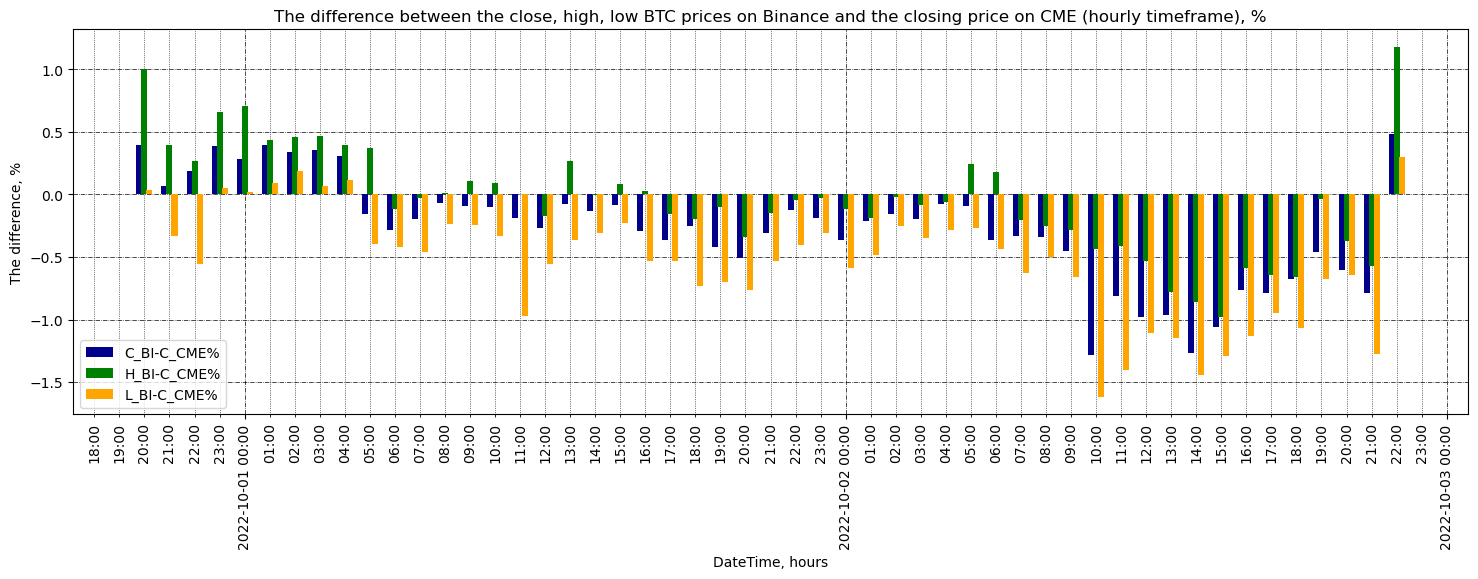

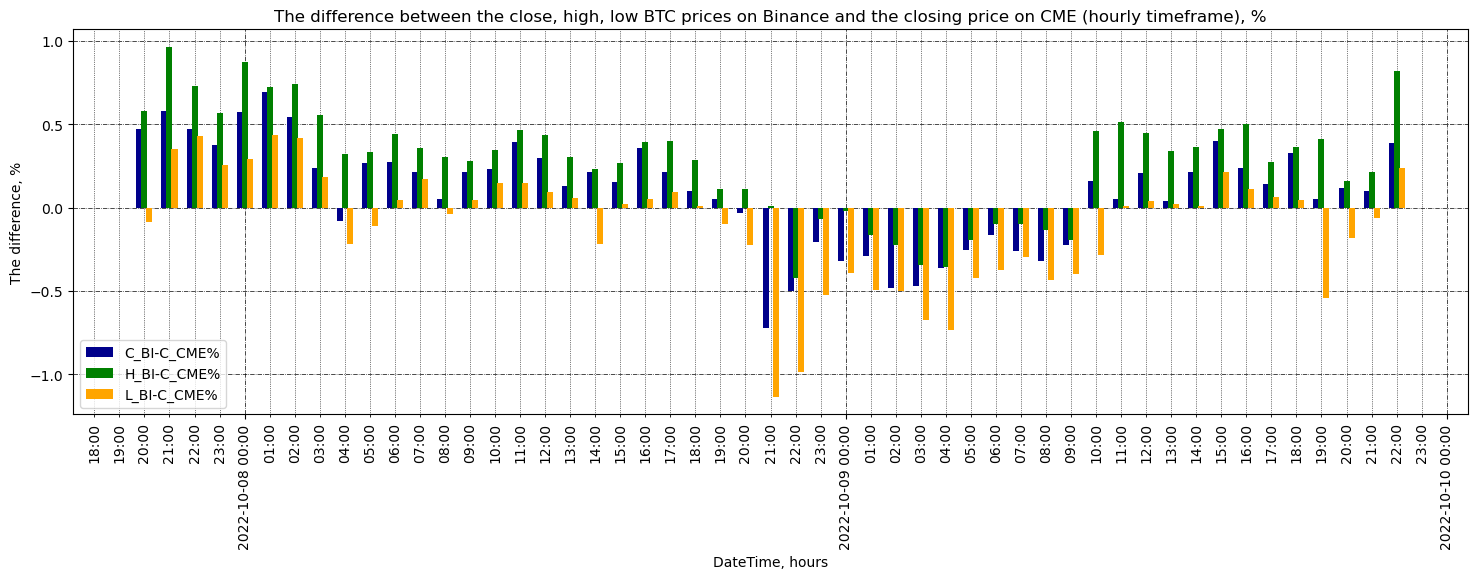

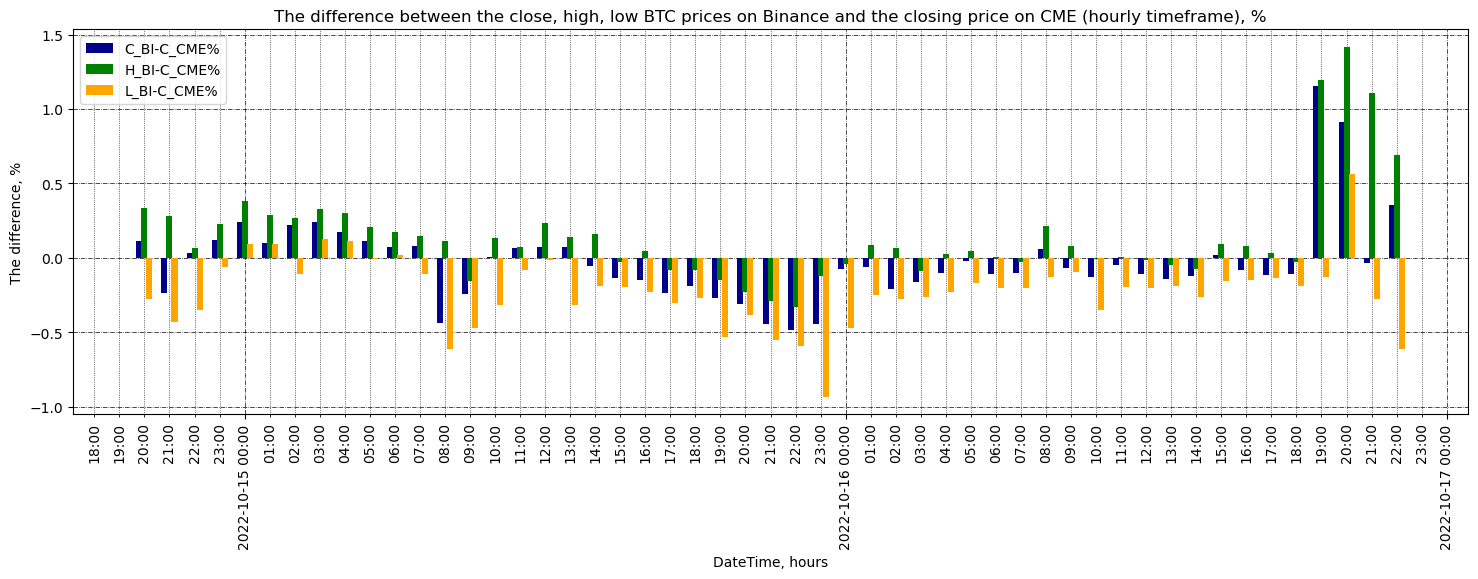

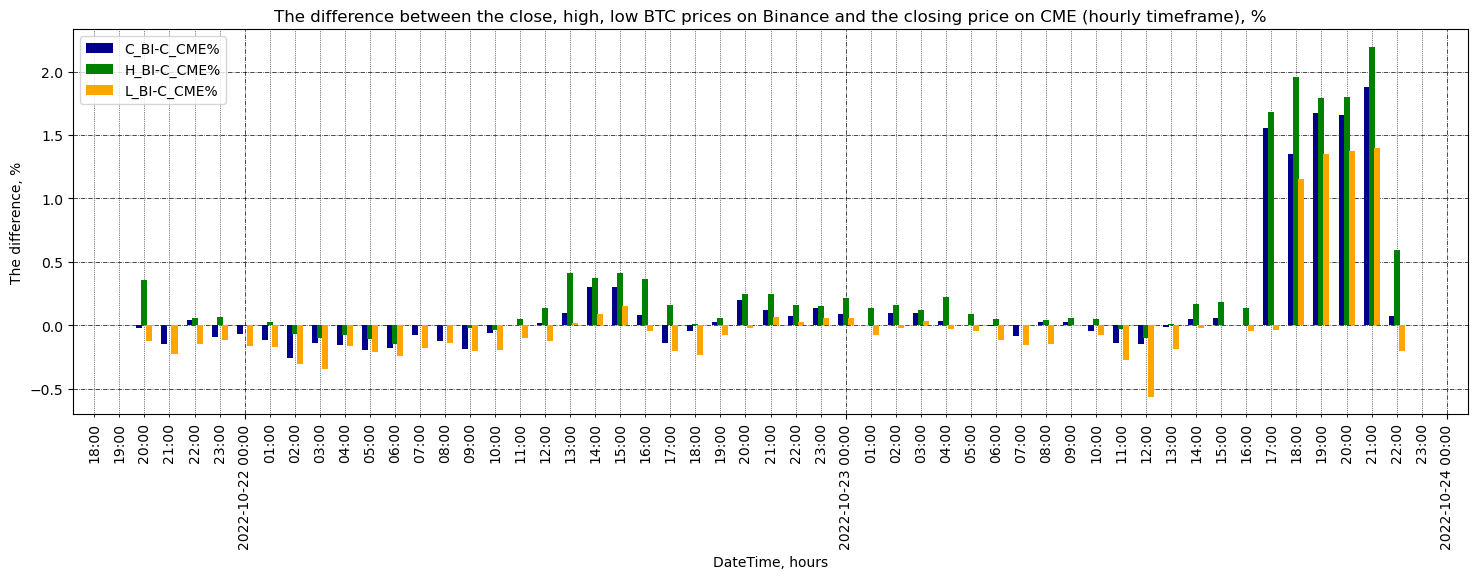

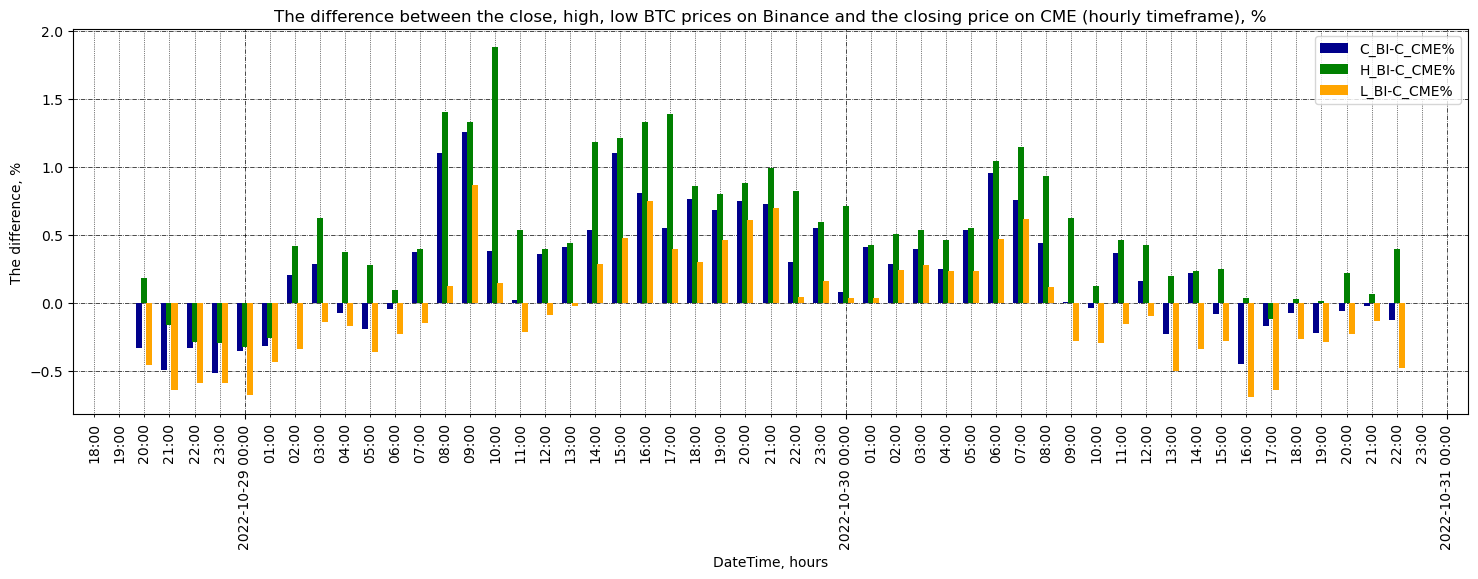

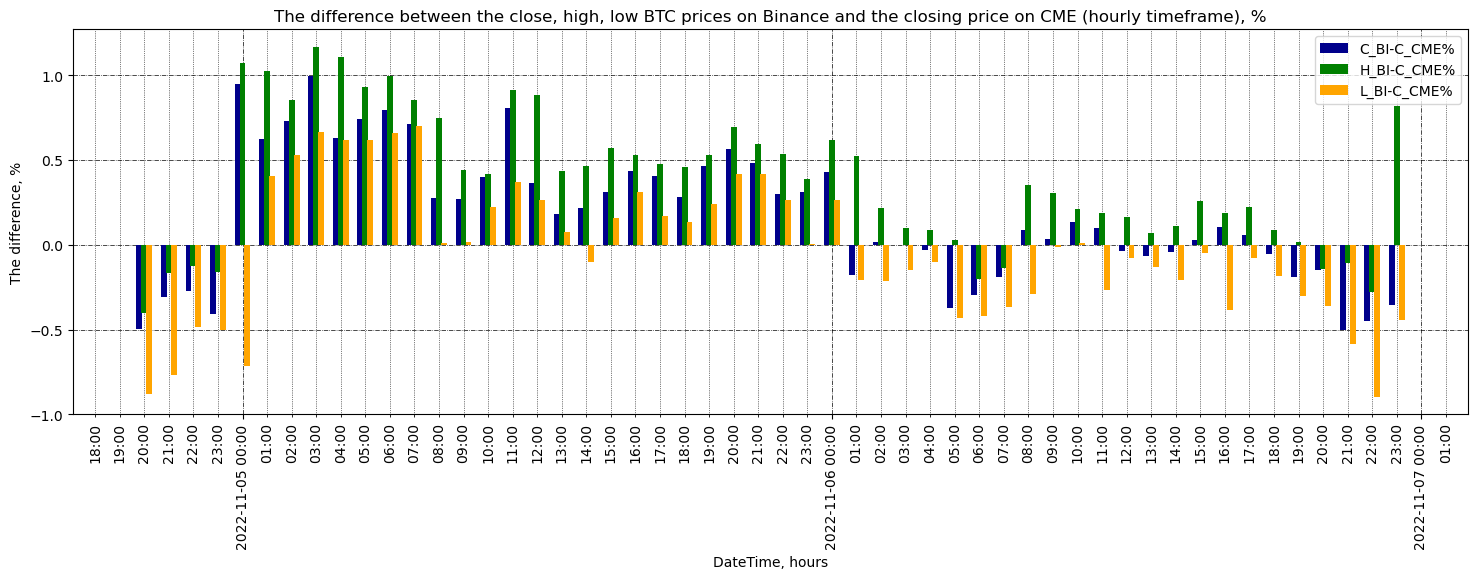

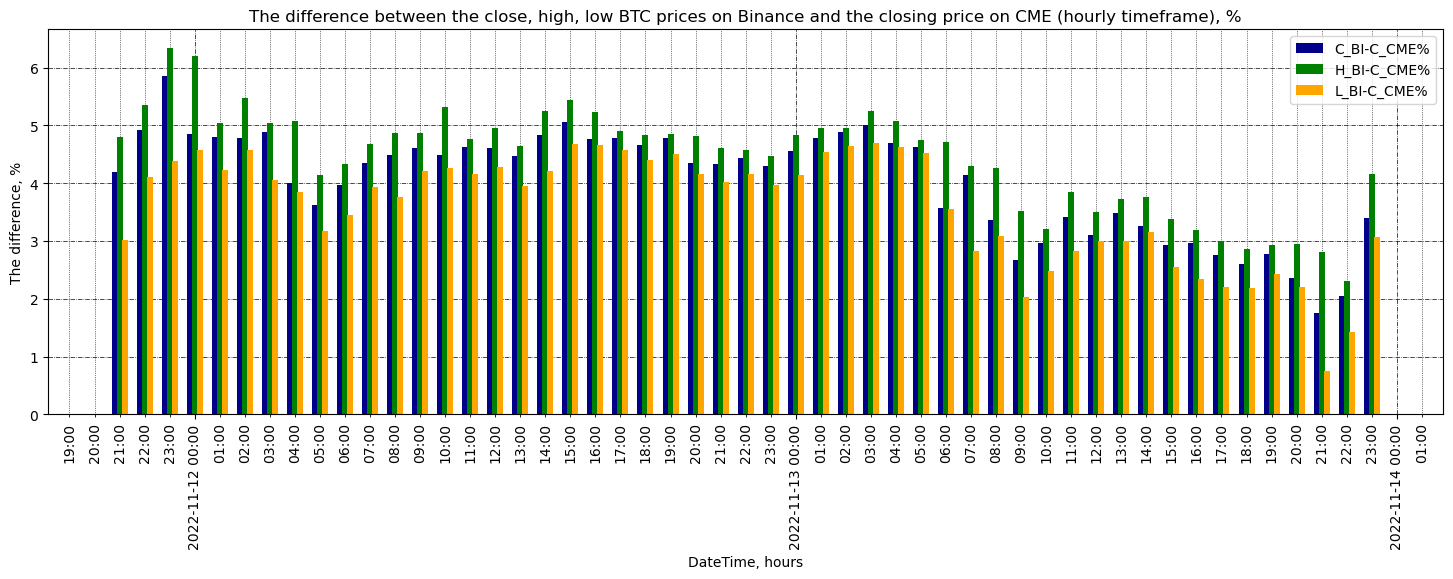

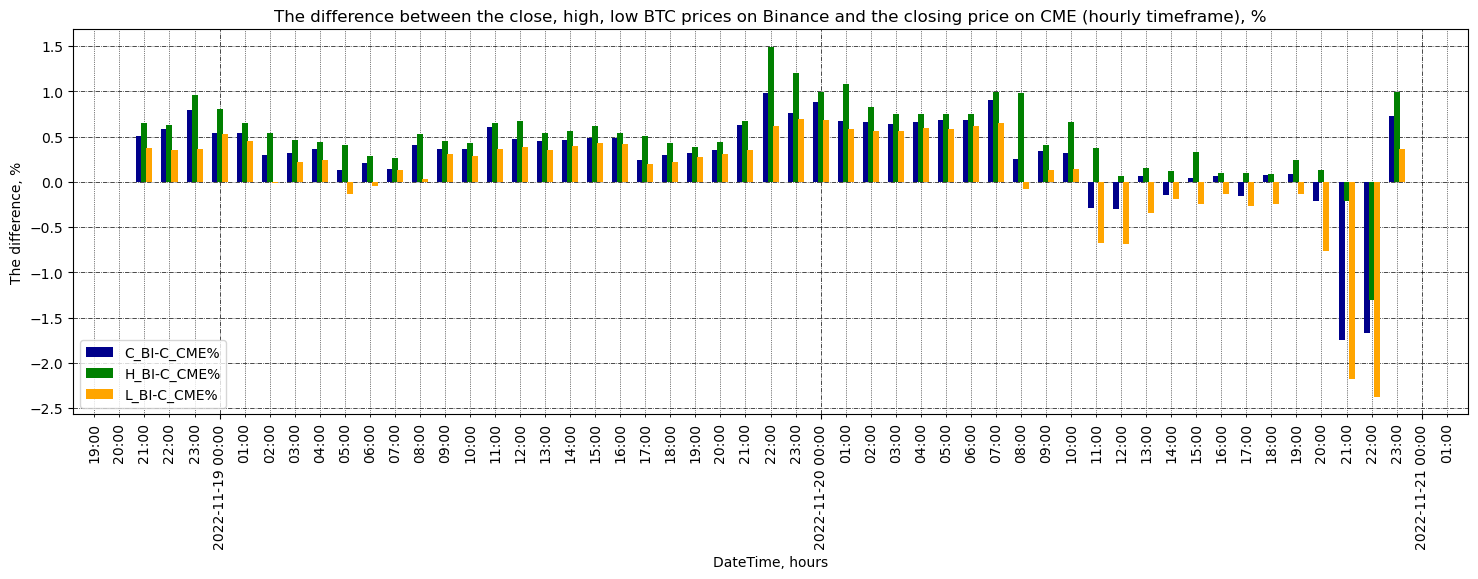

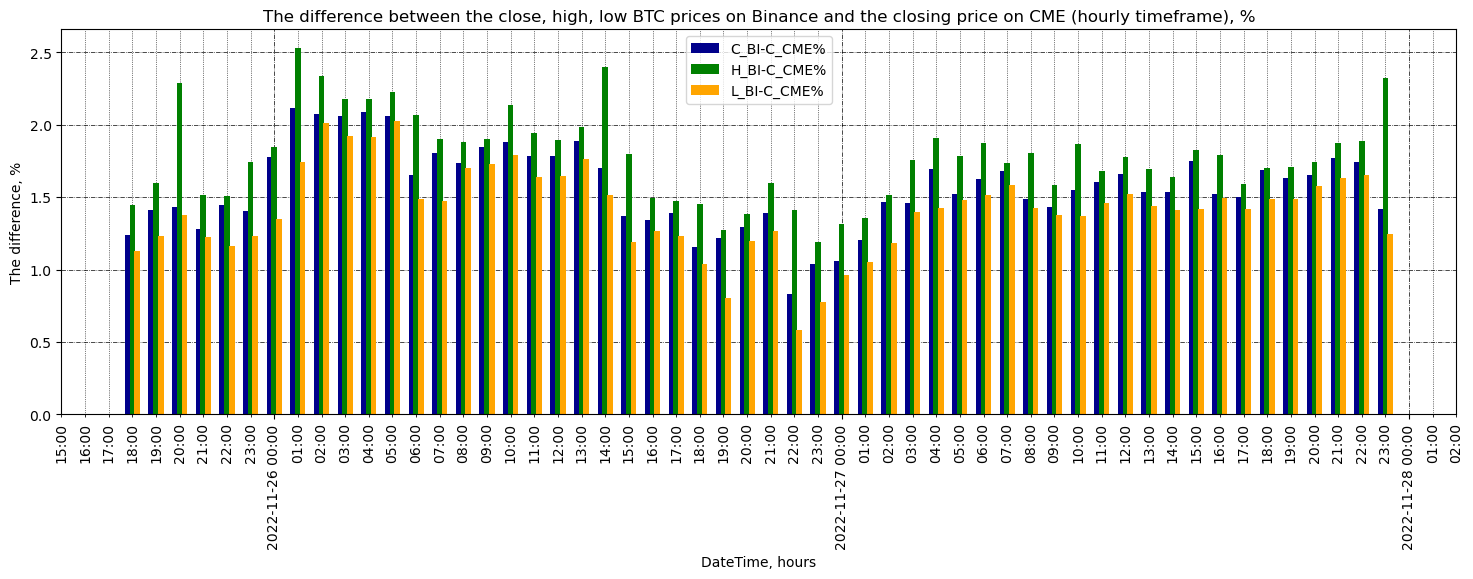

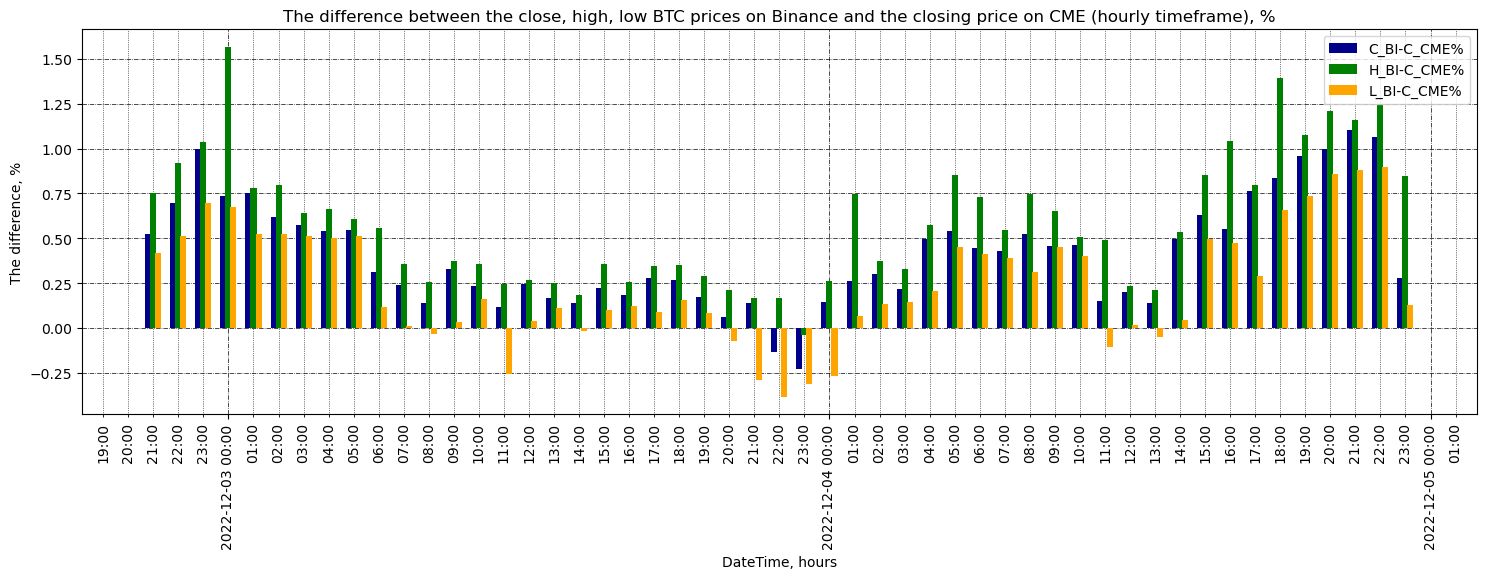

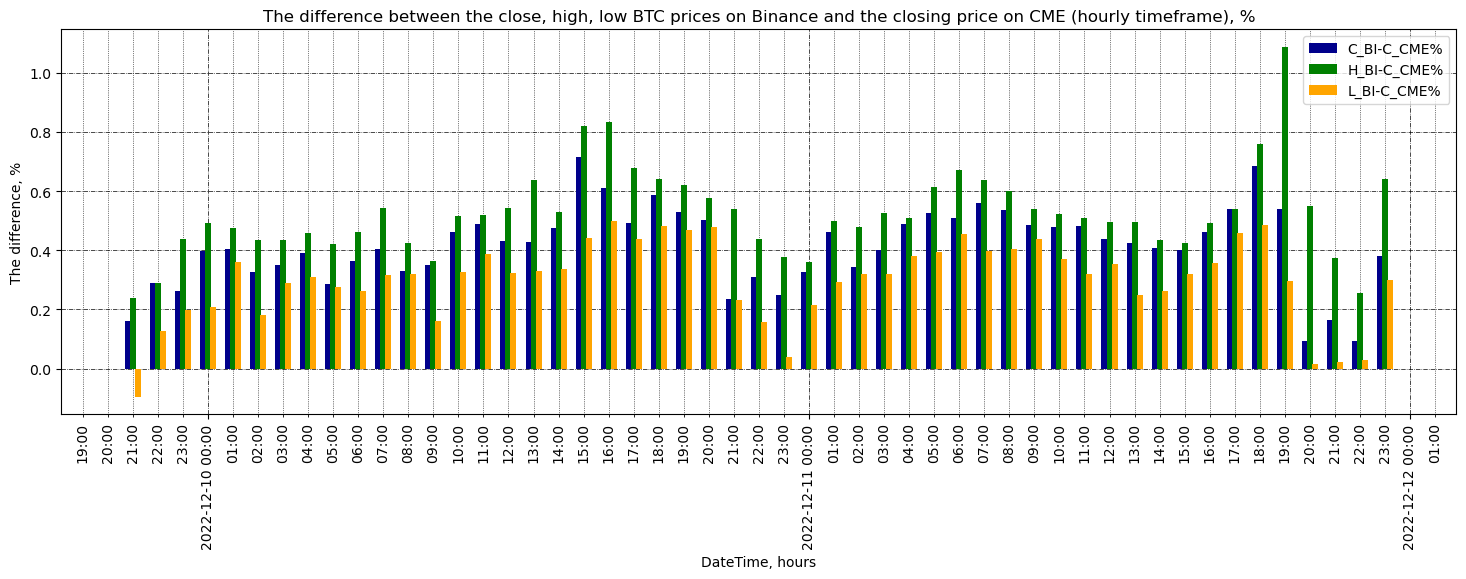

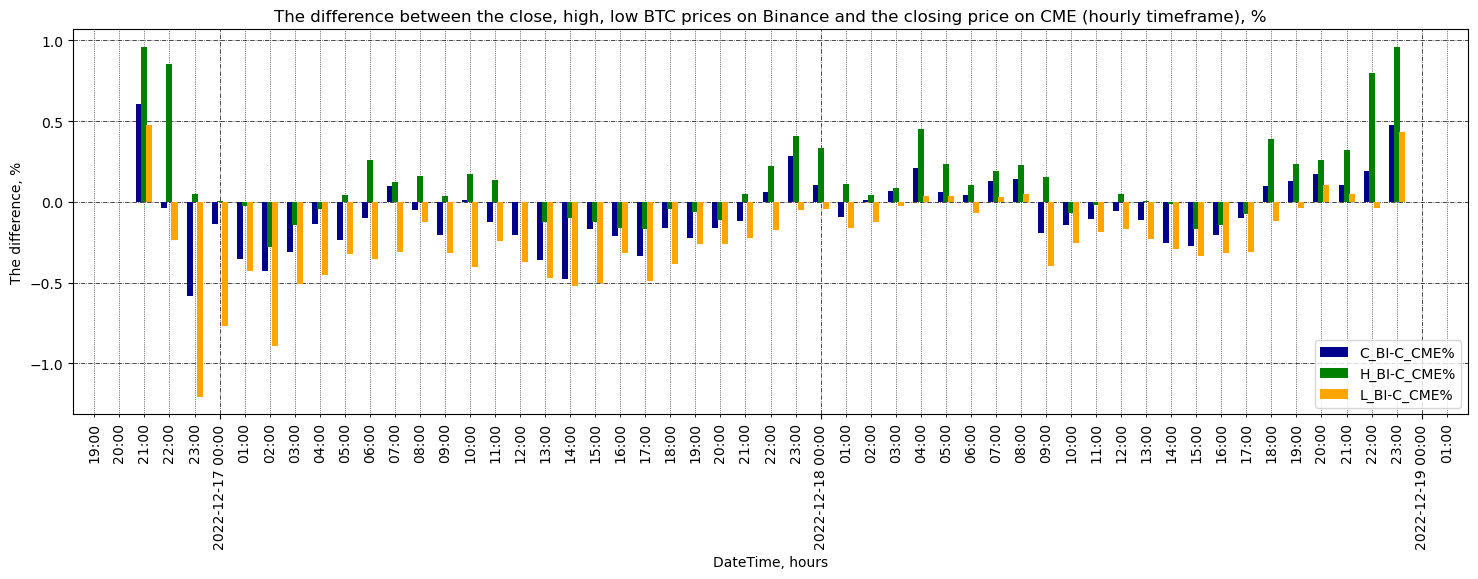

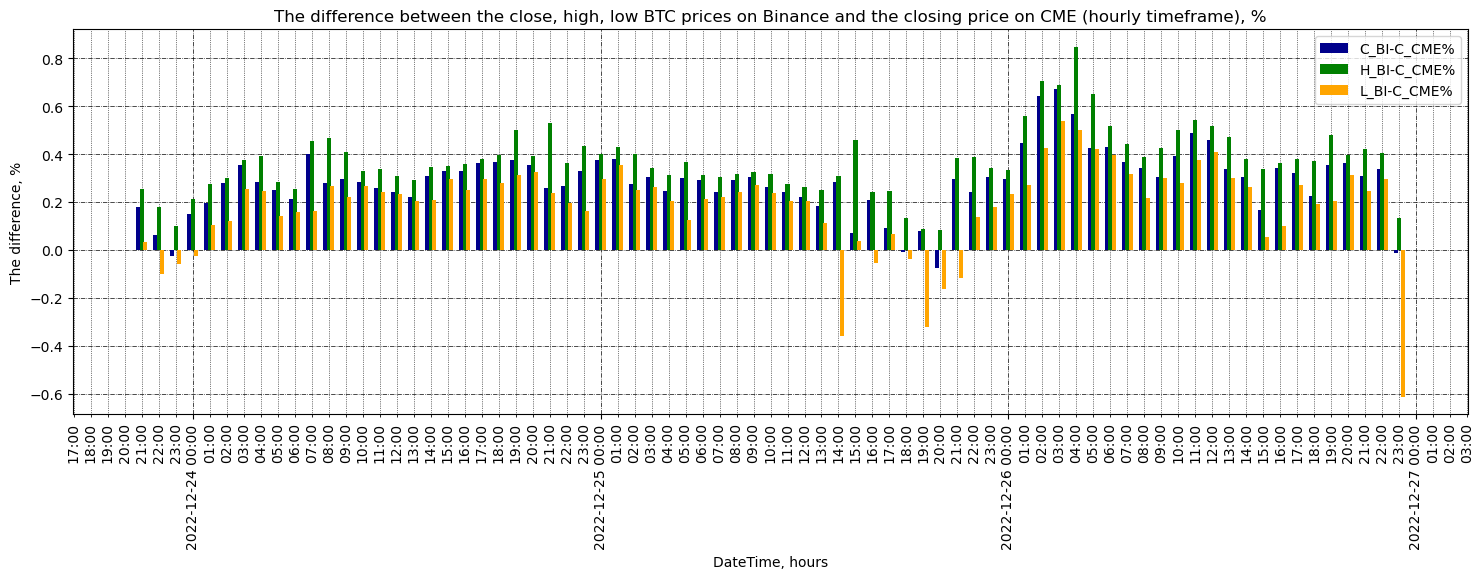

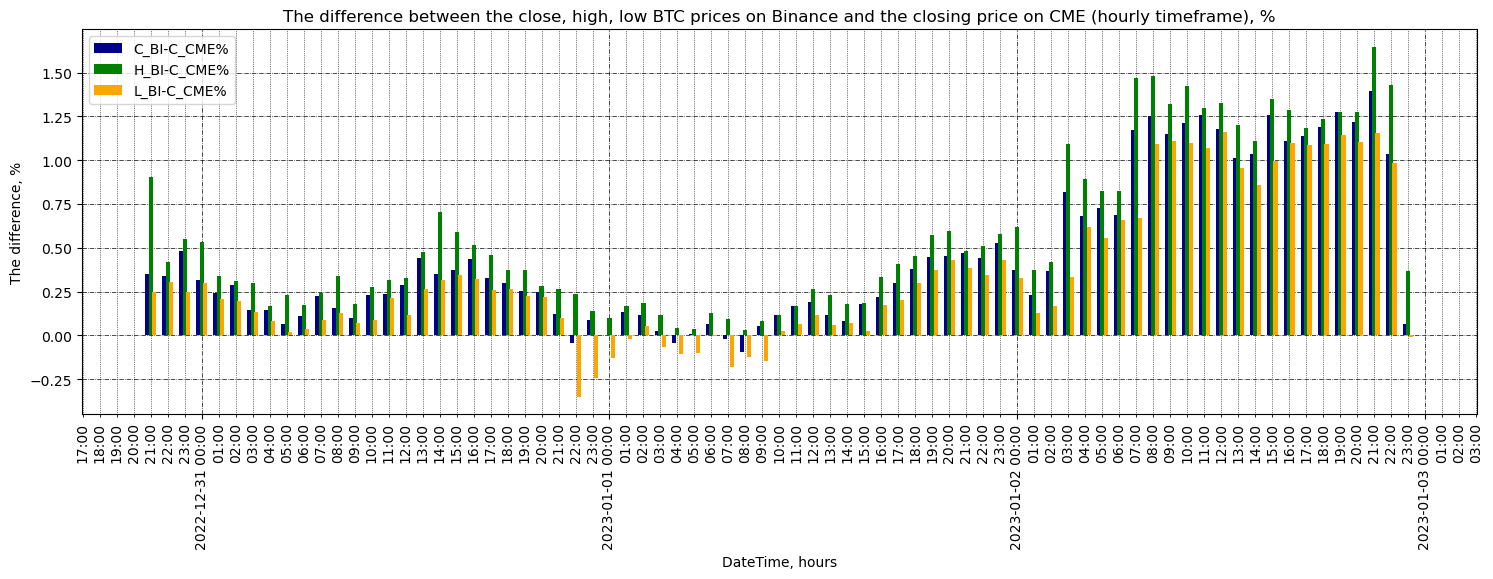

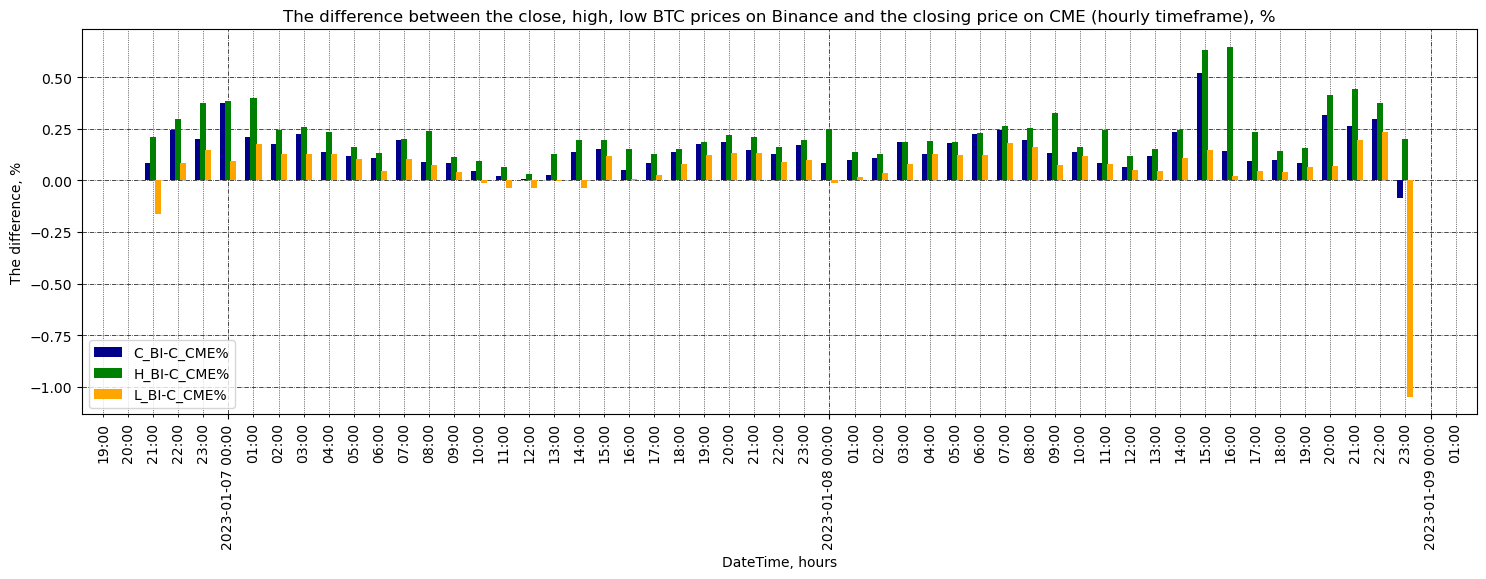

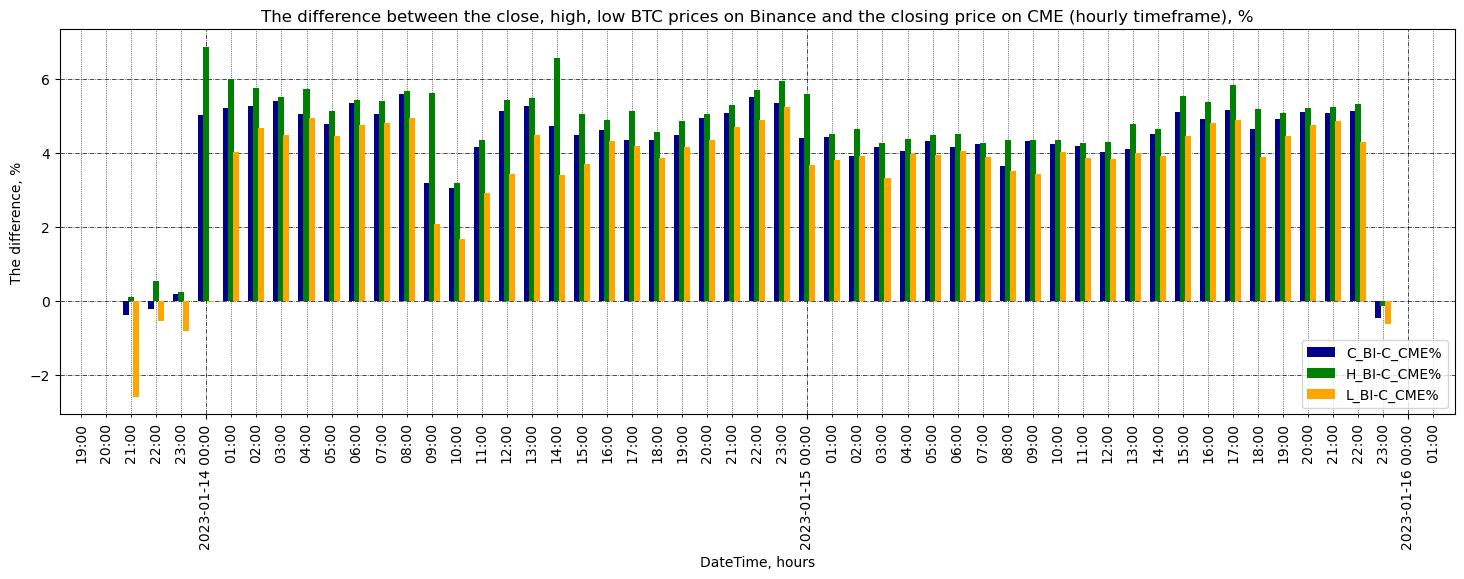

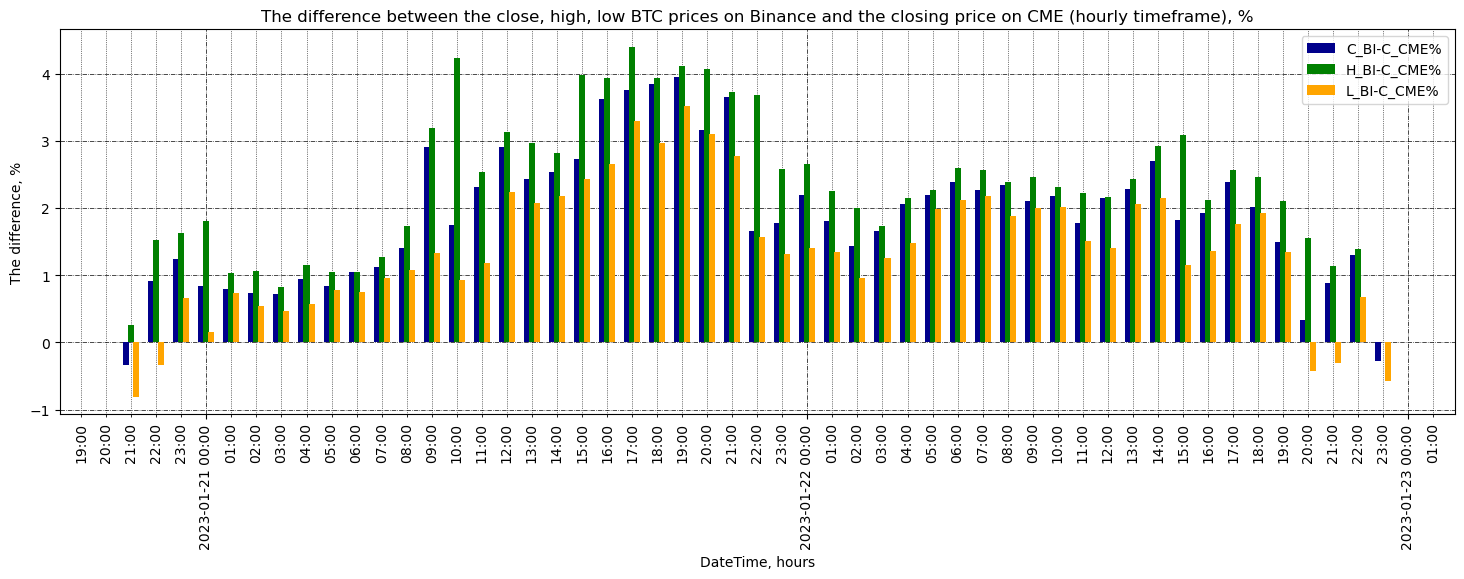

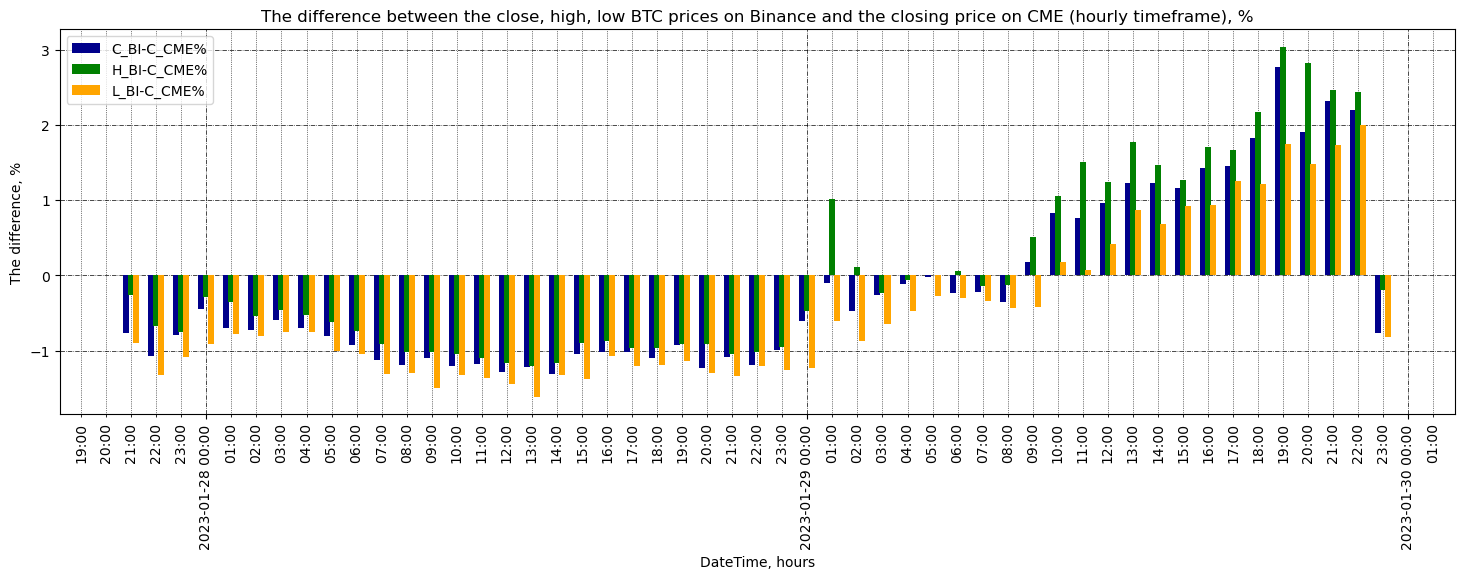

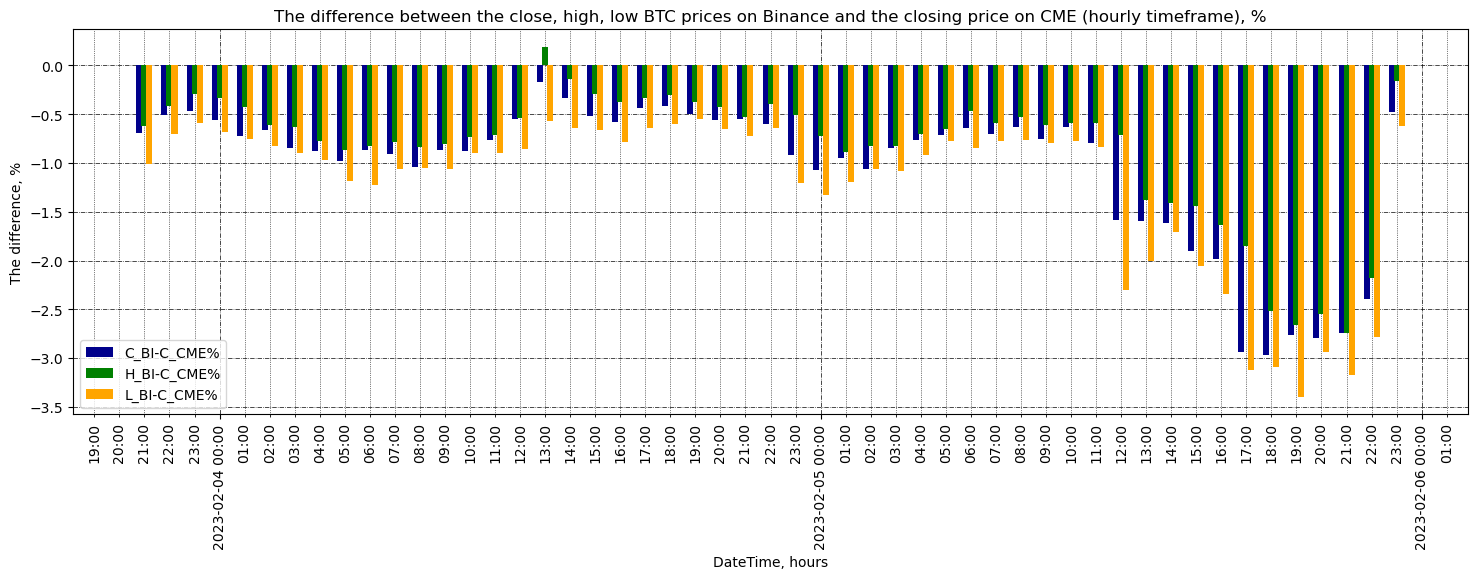

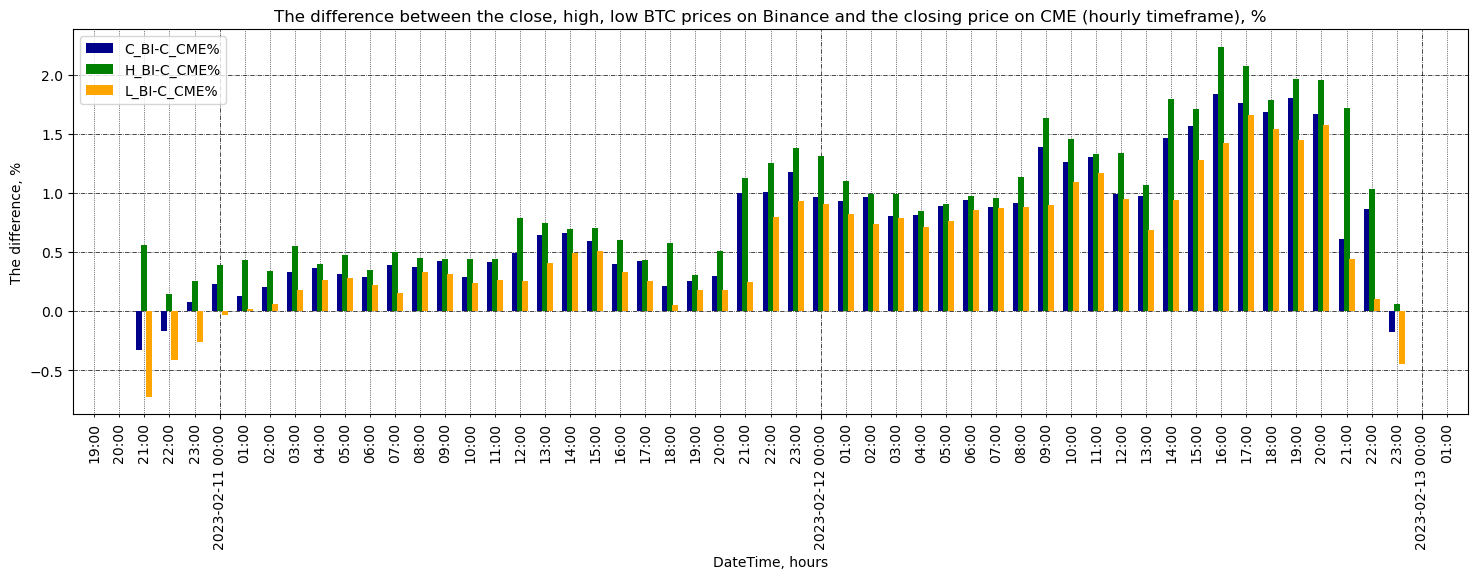

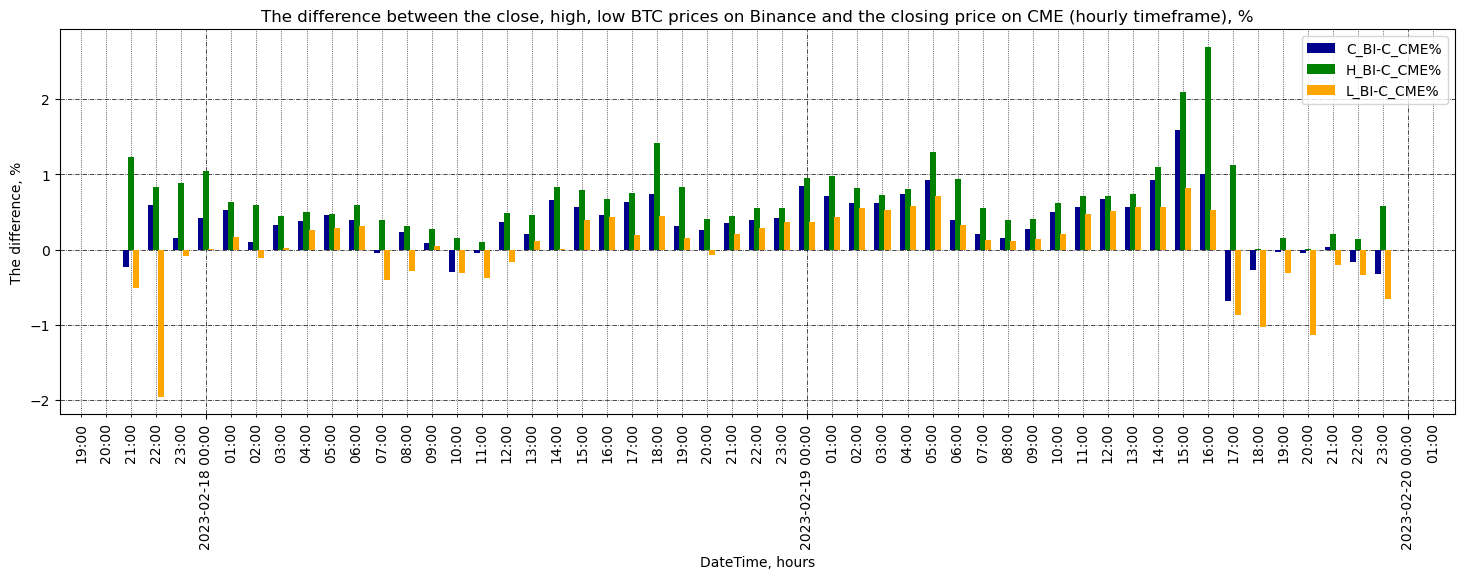

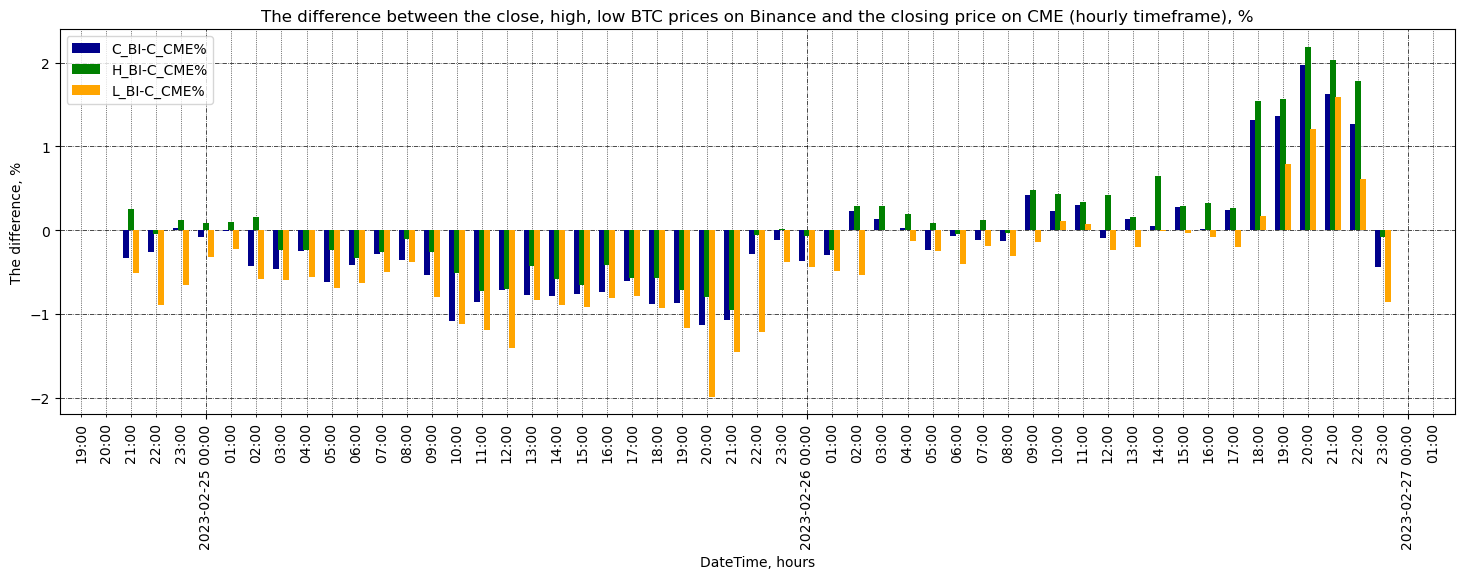

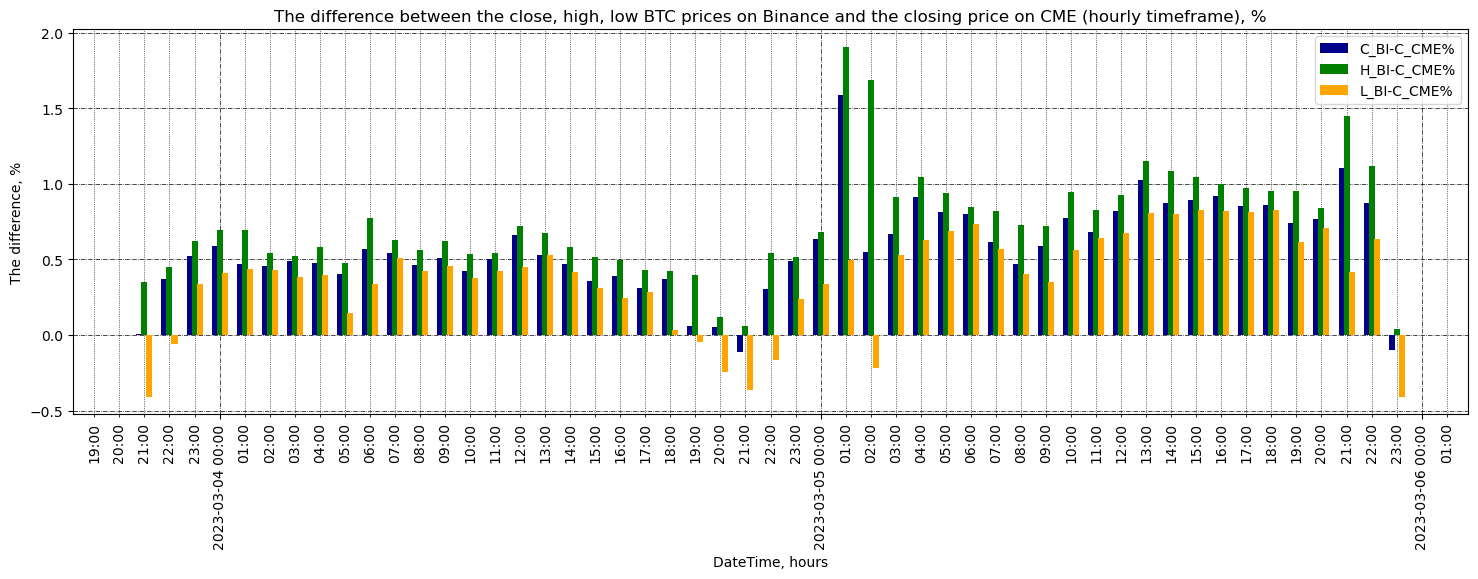

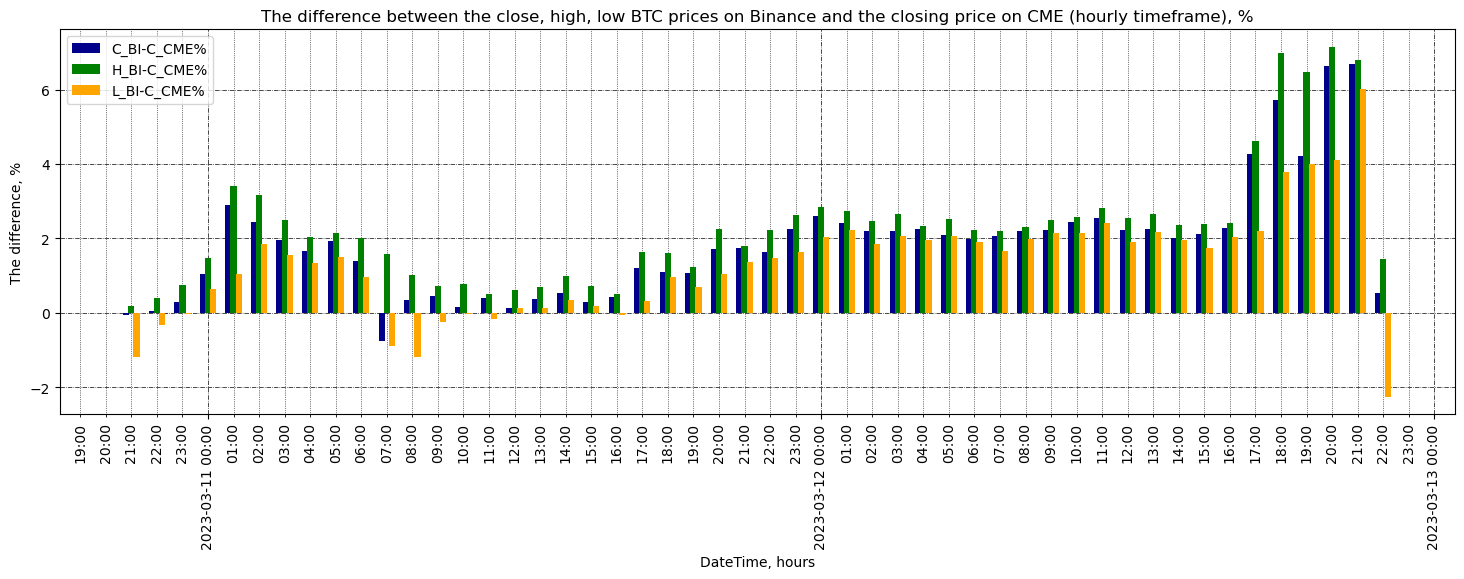

In [29]:
df_periods_str = df_periods.index.strftime("%Y-%m-%d %H:%M:%S%z")
for cnt in range(0, len(df_periods_str), 2):
    df2 = df1.loc[df_periods_str[cnt]:df_periods_str[cnt + 1]]
    df2 = df2.iloc[:, -3:]
    if not df2.empty:
        plot_diff(df2)

## Estimate the percantage of potentially good trades

For "shorts":

In [30]:
sum_starts = 0
sum_ints = 0
# delta = 24
# for cnt in range(0 + delta, len(df_periods_str) - 114 + delta + 2, 2):
for cnt in range(0, len(df_periods_str), 2):
    df2 = df1.loc[df_periods_str[cnt]:df_periods_str[cnt + 1]]
    df2 = df2.iloc[:, -3:]
    if not df2.empty:
        tup_ints = get_short_intervals(df2, 1)
        sum_starts += tup_ints[1]
        sum_ints += tup_ints[2]       
pct_shorts = round(sum_ints * 100 / sum_starts, 2)        
pct_shorts

72.73

For "longs":

In [31]:
sum_starts = 0
sum_ints = 0
# delta = 2
# for cnt in range(0 + delta, len(df_periods_str) - 114 + delta + 2, 2):
for cnt in range(0, len(df_periods_str), 2):
    df2 = df1.loc[df_periods_str[cnt]:df_periods_str[cnt + 1]]
    df2 = df2.iloc[:, -3:]
    if not df2.empty:
        tup_ints = get_long_intervals(df2, -1)
        sum_starts += tup_ints[1]
        sum_ints += tup_ints[2]        
pct_longs = round(sum_ints * 100 / sum_starts, 2)        
pct_longs

79.01

## Conclusion

* The percantage of potentially good trades:
    * short: 72.73 %
    * long: 79.01 %
   
The values are high but:
   * the price can cross the CME closing price multiple times during one weekend;
   * the changes can be very quick;
   * the leverage can can change the values.
   
   So in real life, the values will be less.
* Binance BTC price have significant deviations from CME BTC closing price (more than 1%) during the weekend;
* Binance BTC price significantly deviates in both directions;
* Binance BTC price is tending towards CME BTC closing price and can cross it several times some weekends.

For many other cryptocurrency exchanges the situation is similar to Binance. One of possible reasons is that CME is used by big institutional investors and funds, so the CME volume can influence the market despite its portion is not very big in total volume of all exchanges.


